# Notes on current version:
For TOC if missing from command line try
jupyter nbextensions_configurator enable
then toggle nbextensions, restart.

1. 1.9.2020 Managed to convert ODE models for economic extension to transition model ready for stochastic simulation, using separate birth death list
            See section on SC2UIR model. Not done for other two economic extensions yet
2. 1.9.2020 Implemented stochastic simulation (Tau-leap method) using PyGom inbuilt capabilities: for SCIR simulation only so far
            Neeed to use integer N>>1, not 1.0, for stochastic simulation. Calculates in a few minutes for N=10000, rescaled ICUfrac to 0.02 (x10). N=100000 didn't finish in 10m.

In [1]:
# import required packages
import os 
import csv
from sympy import symbols, init_printing
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sb
from matplotlib import pyplot as plt
import sympy
import itertools
import scipy
import datetime
import matplotlib.dates as mdates
from pygom import DeterministicOde, Transition, SimulateOde, TransitionType, SquareLoss
from scipy.optimize import minimize

import pickle as pk
import jsonpickle as jpk

from cycler import cycler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pwlf

In [2]:
# Jupyter Specifics
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [3]:
savefigs = False # whether to save specific figures for paper to .../figures directory

# Model Definitions

In [4]:
from models import *

# Extract data from Johns Hopkins data base

## Definition of data extraction fuctions get_data and get_country_data

In [5]:
import numpy as np
import csv
import itertools
import matplotlib
%matplotlib inline
import seaborn as sb
from matplotlib import pyplot as plt
from cycler import cycler
import datetime
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pwlf
import sys
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
global dates_jhu,dates_owid,dates_ox,fmt_jhu,fmt_owid,fmt_ox

In [6]:
def get_data(jhu_file):
    dat = []
    with open(jhu_file, newline='') as csvfile:
        myreader = csv.reader(csvfile, delimiter=',')
        popdat = []
        i = 0
        for row in myreader:
            if i != 0:
                poplist = []
                j = 0
                for elt in row:
                    if j >= 4:
                        poplist.append(int(elt))
                    elif j == 0:
                        poplist.append(elt)
                    elif j == 1:
                        poplist[0]=(elt,poplist[0])
                    j = j+1
                popdat.append(poplist)
            else:
                popdat.append(row)
            # print(popdat[i])
            i = i + 1;
    # dates
    popdat0=['dates']
    for elt in popdat[0][4:]:
        popdat0.append(elt)
    popdat[0] = [pop for pop in popdat0]
    # print('popdat[0]',popdat[0])
    # totals over all countries
    totals = np.zeros(len(popdat[0])-1,dtype=int)
    for row in popdat[1:]:
        totals = totals + np.array(row[1:])
    totals = list(np.asarray(totals))
    # print(totals)
    popkeyed = {poplist[0]: poplist[1:] for poplist in popdat}
    popkeyed.update({'dates':popdat[0][1:]})
    popkeyed.update({('World',''):totals})
    # del popkeyed[('d','a')]
    # assemble totals for countries with multiple regions
    total = np.zeros(len(popkeyed['dates']),dtype=int)
    poptotkeyed = {}
    for country,tseries in popkeyed.items():
        if country!='dates' and country[1] != '': # it seems that UK is single exception with both '' and non '' regions, UK total is then UK overseas
            countrytotal = (country[0],'Total')
            if countrytotal in poptotkeyed:
                # print(country,popkeyed[country],poptotkeyed[countrytotal])
                total = np.array(tseries)[:]+np.array(poptotkeyed[countrytotal])[:]
            else:
                total =  np.array(tseries)                        
            poptotkeyed.update({countrytotal:list(total)})
    for countrytotal,tseries in poptotkeyed.items():
        total = np.array(tseries)
        popkeyed.update({countrytotal:list(total)})
    return popkeyed

In [7]:
def Float(x):
    try:
        rtn = float(x)
    except:
        rtn = float('NaN')
    return rtn

In [8]:
# from covid_data_explore-jhu-j
def get_country_data(country_s='World', datatype='confirmed', firstdate=None, lastdate=None):
    if isinstance(country_s,str):
        country = (country_s,'')
    else:                               # single ('country','reg') entry
        country = country_s
    popkeyed = covid_ts[datatype]
    
    dates = popkeyed['dates']
    fmt = '%m/%d/%y'
    xx = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    if firstdate:
        firstdate_d = datetime.datetime.strptime(firstdate,fmt)
    else:
        firstdate_d = datetime.datetime.strptime(dates[0],fmt)
    if lastdate:
        lastdate_d = datetime.datetime.strptime(lastdate,fmt)
    else:
        lastdate_d = datetime.datetime.strptime(dates[-1],fmt)    
    daystart = (firstdate_d-xx[0]).days
    daystop = (lastdate_d-xx[-1]).days

    try:
        yy = popkeyed[country]
        # print(country)
    except:
            print('country data not found',country)
            return None,None,None
    yyf = [Float(y) for y in yy]
    
    if daystart <0:
        xx0 = [xx[0]+datetime.timedelta(days=i) for i in range(daystart,0)]
        yy0 = [0.]*(-daystart)
    else:
        xx0 = []
        yy0 = []
    if daystop > 0:
        xx1 = [xx[-1]+datetime.timedelta(days=i) for i in range(daystop)]
        yy1 = [0.]*(daystop)
    else:
        xx1 = []
        yy1 = []       
    xx = xx0 + xx + xx1
    xxf = [Float((x-firstdate_d).days) for x in xx ]
    
    yy = yy0 + yyf + yy1
    return xx,xxf,yy 



In [9]:
def get_country_data_nyw(country_s='World', datatype='confirmed', firstdate=None, lastdate=None):
    if isinstance(country_s,str):
        country = (country_s,'')
    else:                               # single ('country','reg') entry
        country = country_s
    popkeyed = covid_ts[datatype]
    
    dates = popkeyed['dates']
    fmt = '%m/%d/%y'
    xx = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    if firstdate:
        firstdate_d = datetime.datetime.strptime(firstdate,fmt)
    else:
        firstdate_d = datetime.datetime.strptime(dates[0],fmt)
    if lastdate:
        lastdate_d = datetime.datetime.strptime(lastdate,fmt)
    else:
        lastdate_d = datetime.datetime.strptime(dates[-1],fmt)    
    daystart = (firstdate_d-xx[0]).days
    daystop = (lastdate_d-xx[-1]).days
    
    try:
        yy = popkeyed[country]
        # print(country)
    except:
            print('country data not found',country)
            return None,None      
    yyf = [Float(y) for y in yy]

    yy0 = []
    yy1 = []  
    if daystart>len(yyf):
        print('Error: start date does not overlap with available data')
        return None,None
    elif daystart>0:
        yyf = yyf[daystart:]
    elif daystart <0:
        yy0 = [0.]*(-daystart)
        
    if daystop < 0:
        yyf = yyf[:daystop]  
    elif daystop > 0:
        yy1 = [0.]*(daystop)
    yyf = yy0 + yyf + yy1
    xxf = [float(x) for x in range(len(yyf))]
    return xxf,yyf 

## JHU data

In [10]:
base = '../../covid-19-JH/csse_covid_19_data/csse_covid_19_time_series/'
confirmed = get_data(base+'time_series_covid19_confirmed_global.csv')
deaths = get_data(base+'time_series_covid19_deaths_global.csv')
recovered = get_data(base+'time_series_covid19_recovered_global.csv')
covid_ts = {'confirmed':confirmed,'deaths':deaths,'recovered':recovered}
dates_jhu = covid_ts['confirmed']['dates']
countries_jhu = [(row[0],row[1]) for row in confirmed][1:]
print("number of countries listed",len(countries_jhu))
i=0
for country in countries_jhu:
#    print(i,country)
    i = i + 1

number of countries listed 274


## Get data for one country

In [11]:
# assumed data starting on firstdate
test_country='Germany'
N = 80000000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0,

## OWID data

In [12]:
import csv
owid_file = '../../covid-19-owid/public/data/owid-covid-data.csv'
covid_owid = []
with open(owid_file,'r',newline='') as fp:
    myreader = csv.DictReader(fp,delimiter=',')
#    rows = list(itertools.islice(myreader,4))
    for row in myreader:
        covid_owid.append(row)
covid_owid[0].keys()

odict_keys(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy'])

In [13]:
def get_data_owid(owid_file,database='owid',datatype='confirmed',dataaccum = 'cumulative'):
    import numpy as np
    import datetime
    import matplotlib.dates as mdates
    
    global covid_owid, fmt_jhu, fmt_owid
    if not covid_owid:
        with open(owid_file, 'r', newline='') as csvfile:
            myreader = csv.DictReader(csvfile,delimiter=',')
            for row in myreader:
                covid_owid.append(row)
        close(owid_file)
        
    # for key in covid_owid[0].keys():   # to loop through all keys
    
    if datatype == 'confirmed':
        if dataaccum == 'cumulative':
            key = 'total_cases'
        elif dataaccum == 'weekly':
            key = 'new_cases_smoothed'
        else:
            key = 'new_cases'
    elif datatype == 'recovered':
        print('data for recovered cases not available in OWID database')
        key = None
    elif datatype == 'deaths':
        if dataaccum == 'cumulative':
            key = 'total_deaths'
        elif dataaccum == 'weekly':
            key = 'new_deaths_smoothed'
        else:
            key = 'new_deaths'
    elif datatype == 'tests':
        if dataaccum == 'cumulative':  # reporting intervals often sporadic so better to use smoothed weekly
            # key = 'total_tests'
            key = 'new_tests_smoothed'  # will adjust to cumulative below
        elif dataaccum == 'weekly':
            key = 'new_tests_smoothed'
        else:
            key = 'new_tests'          # reporting intervals often sporadic so better to use smoothed weekly
    elif datatype =='stringency':
        key = 'stringency_index'
    elif datatype == 'recovered':
        print('data for recovered cases not available in OWID database')
        key = None
        return 
    else:
        print('data for ', datatype,'not available or not yet translated in OWID database')
        key = None
        return
   
    countries = np.unique(np.array([dd['location'] for dd in covid_owid]))
    dates = np.unique(np.array([dd['date'] for dd in covid_owid]))
    dates.sort()
    fmt_owid = '%Y-%m-%d'
    dates_t = [datetime.datetime.strptime(dd,fmt_owid) for dd in dates ]
    firstdate = dates[0]
    lastdate = dates[-1]
    firstdate_t =  dates_t[0]
    lastdate_t =  dates_t[-1]

    daystart = 0
    daystop = (lastdate_t-firstdate_t).days
    
    popkeyed = {country: np.zeros(daystop+1,dtype=float) for country in countries} 
    
    for dd in covid_owid:
        country = dd['location']
        day = (datetime.datetime.strptime(dd['date'],fmt_owid)-firstdate_t).days
        popkeyed[country][day] = float(dd[key]) if not dd[key]=='' else 0.0 
        
    # popkeyed = {country: np.transpose(np.array([[dd['date'],dd[key]] for dd in covid_owid if dd['location'] == country])) for country in countries}
    # popkeyed = {country: np.array([float(dd[key]) if not dd[key]=='' else 0.0 for dd in covid_owid if dd['location'] == country]) for country in countries} 

    if datatype == 'tests' and dataaccum == 'cumulative':  # assemble cumulative tests from smooth daily tests
        for country in countries:
            data = popkeyed[country]
            sumdata= np.zeros(len(data))
            sum = 0.0
            for i,d in enumerate(data):
                sum = sum + d
                sumdata[i] = sum
            popkeyed.update({country:sumdata})

    fmt_jhu = '%m/%d/%y'
    popkeyed.update({'dates': [date.strftime(fmt_jhu) for date in dates_t]})   # dates are set to strings in jhu date format for compatibility
    return popkeyed

In [14]:
owid_file = '../../covid-19-owid/public/data/owid-covid-data.csv'
confirmed_owid=get_data_owid(owid_file,database='owid',datatype='confirmed',dataaccum = 'cumulative')
recovered_owid = None
deaths_owid=get_data_owid(owid_file,database='owid',datatype='deaths',dataaccum = 'cumulative')
tests_owid=get_data_owid(owid_file,database='owid',datatype='tests',dataaccum = 'cumulative')
stringency_owid=get_data_owid(owid_file,database='owid',datatype='stringency',dataaccum = 'daily')
covid_owid_ts= {'confirmed':confirmed_owid,'deaths':deaths_owid,'recovered':recovered_owid, 'tests': tests_owid , 'stringency': stringency_owid}
dates_owid = covid_owid_ts['confirmed']['dates']

In [15]:
def truncx(xx,daystart,daystop):
    """truncate array xx to run from daystart to daystop
       do this before trying to extend the arrays if required"""
    daymin = max(daystart,0)
    daymax = min(daystop,(xx[-1]-xx[0]).days)
    return xx[daymin:daymax+1]

def truncy(xx,yy,daystart,daystop):
    """truncate arrays xx and yy to run from daystart to daystop
       do this before trying to extend the arrays if required"""
    daymin = max(daystart,0)
    daymax = min(daystop,(xx[-1]-xx[0]).days)
    return yy[daymin:daymax+1]

def plotCountry_(country_s, datatype='confirmed', dataaccum='cumulative', fittype=None, ax=None, ax2=False,
                symbol='o--', step=None, firstdate=None, lastdate=None, intdates=False, linecolor=None, maxyval=None, minconfirmed=0,nsegments=3,database='jhu'):
    """ plots selected data for a list of countries or single country
        datatypes allowed are 'confirmed','deaths','recovered'
        dataaccum specifies either 'cumulative' or 'daily' or averaged over 7 days 'cum_av_weekly' or 'daily_av_weekly'
        fittypes allowed are currently None, 'piecewise-linear'
        ax graphical axes to use for plot: default None -> new axes
        ax2 true if second axes as twin axes for overlay plotting
        symbol to use for plotting
        step whether to use step plotting instead of points: default None -> points
        firstdate to plot (maybe before first date in data - pad with 0)
        lastdate to plot (maybe after last date in data - pad with 0)
        intdates : whether to plot dates as integers for compatibility (default as dates)
        linecolor is default color to use for a single trace, instead of listed set)
    """
    global covid_ts, covid_ts_owid
    import math
    import warnings
    # extract list of countries in [(country,region),...] format from first parameter
    countries = []
    if isinstance(country_s,list):
        for country in country_s:
            if isinstance(country,str) and database == 'jhu':
                country = (country,'')
            countries.append(country)
    elif isinstance(country_s,str):
        if database == 'jhu':
            countries = [( country_s,'')]
        else:
             countries = [country_s]
    else:                               # single ('country','reg') entry
        countries = [country_s]
        
    # get data with datatype and extend dates to padd desired interval specified by firstdate,lastdate
    if database == 'jhu':
        popkeyed = covid_ts[datatype]
        dates = popkeyed['dates']
        fmt = '%m/%d/%y'
    elif database == 'owid':
        popkeyed = covid_owid_ts[datatype]
        dates = popkeyed['dates']
        fmt = '%m/%d/%y'
        # fmt = '%Y-%m-%d' the owid date format was converted to the jhu date format in get_data_owid
    xxd = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    if firstdate:
        firstdate_d = datetime.datetime.strptime(firstdate,fmt)
    else:
        firstdate_d = datetime.datetime.strptime(dates[0],fmt)
    if lastdate:
        lastdate_d = datetime.datetime.strptime(lastdate,fmt)
    else:
        lastdate_d = datetime.datetime.strptime(dates[-1],fmt)
    daystart = (firstdate_d-xxd[0]).days
    daystop = (lastdate_d-xxd[0]).days
    xx = [0.]*(daystop-daystart+1)
    xx = truncx(xxd,daystart,daystop)
    # print('1 len xx',len(xx))
    
    if daystart <0:
        xx0 = [xx[0]+datetime.timedelta(days=i) for i in range(daystart,0)]
        yy0 = [0.]*(-daystart)
    else:
        xx0 = []
        yy0 = []

    if daystop > (xxd[-1]-xxd[0]).days:
        xx1 = [xxd[-1]+datetime.timedelta(days=i) for i in range(daystop-(xxd[-1]-xxd[0]).days)]
        yy1 = [' ']*(daystop-(xxd[-1]-xxd[0]).days)
    else:
        xx1 = []
        yy1 = []       
    xx = xx0 + xx + xx1
    # print('2 len xx',len(xx))
    #print('len xx1 yy1',len(xx1),len(yy1))
    
    # print('len xx',len(xx))
    if fittype == 'piecewise-linear':
        xxi = [Float((x-xx[0]).days) for x in xx ]
        # print(xxi)
    # print('len xxi',len(xxi))    
    # locator = mdates.MonthLocator()
    locator = mdates.AutoDateLocator(minticks=5, maxticks=13)
    formatter= mdates.ConciseDateFormatter(locator)
    
    if not ax:
        fig,ax = plt.subplots(1,1,figsize=(9,6)) 
        ax2 = ax
    elif ax2:
        ax2 = ax.twinx()
    else:
        ax2 = ax
        
    colors =  ['k', 'b', 'c', 'm', 'y', 'g', 'olive', 'chocolate']
        
    i = 0
    j = 0
    for country in countries:
        try:
            yyd = popkeyed[country]
            if np.max(yyd) >= minconfirmed:
                j = j+1
            else:
                i = i + 1
                continue
        except:
            print('country not found',country)
            i = i + 1
            continue
        yy = truncy(xxd,yyd,daystart,daystop)
        # print(country,'1 len yy yyd',len(yy),len(yyd))
        yyf = [Float(y) for y in yy]
        yy = yy0 + yyf + yy1
        # print(country,'2 len yy',len(yy))
        # ymax=np.max(np.array(yy))
        yyf = [Float(y) for y in yy]
        if dataaccum == 'daily':
            yy = [0.]*len(yy)
            yy[0] = yyf[0]
            for k in range(1,len(yy)):
                yy[k] = yyf[k]-yyf[k-1]   
        elif dataaccum == 'cum_av_weekly':
            yy = [0.]*len(yy)
            moving_av = 0.
            for k in range(len(yy)):
                if k-7 >= 0:
                    moving_av = moving_av - yyf[k-7]
                moving_av = moving_av + yyf[k]
                yy[k] = moving_av/min(7.0,float(k+1))
        elif dataaccum == 'daily_av_weekly':
            yy = [0.]*len(yyf)
            yy[0] = yyf[0]
            for k in range(1,len(yy)):
                yy[k] = yyf[k]-yyf[k-1]
            yyf = [y for y in yy]
            yy = [0.]*len(yy)
            moving_av = 0.
            for k in range(len(yy)):
                if k-7 >= 0:
                    moving_av = moving_av - yyf[k-7]
                moving_av = moving_av + yyf[k]
                yy[k] = moving_av/min(7.0,float(k+1))
        if intdates:
            xx = range(len(xx))
        
        if step:
            ax2.step(xx,yy,label = country[0])
        else:
            # print(ax,ax2)
            # ax2.set_ylim(ymax,0)
            if linecolor:
                color = linecolor
            else:
                color = colors[i]

            ax2.plot(xx, yy, symbol, markersize=3, color = color, alpha=0.8, label = country[0])

        if maxyval: ax.set_ylim(0,maxyval)
        if maxyval: ax2.set_ylim(0,maxyval)
            
        plt.title(country[0]+'-'+country[1])  # +' '+datatype)
        if fittype == 'piecewise-linear':    
            warnings.filterwarnings("ignore", message="Warning: zero length interval encountered in pwlf.py calc_slopes")
            # initialize piecewise linear fit with your x and y data
            # yyf = [Float(y) for y in yy]
            yyf = [Float(y) if not math.isnan(y) else 0.0 for y in yy]
            # print(yyf)
            my_pwlf = pwlf.PiecewiseLinFit(xxi, yyf)
            # fit the data for three line segments
            res = my_pwlf.fit(nsegments)
            
            ppp = my_pwlf.p_values(method='non-linear', step_size=1e-4)
            se = my_pwlf.se  # standard errors
            parameters = np.concatenate((my_pwlf.beta,
                             my_pwlf.fit_breaks[1:-1]))
            header = ['Parameter type', 'Parameter value ', 'Standard error  ', 't               ', 'P > np.abs(t) (p-value)']
            print(*header, sep=' | ')
            fltfmt = "{:12.3f}".format
            values = np.zeros((parameters.size, 5), dtype=np.object_)
            values[:, 1] = [fltfmt(np.around(term, decimals=3)) for term in parameters]
            values[:, 2] = [fltfmt(np.around(term, decimals=3)) for term in se]
            values[:, 3] = [fltfmt(np.around(term, decimals=3)) for term in parameters/se]
            values[:, 4] = [fltfmt(np.around(term, decimals=3)) for term in ppp]
            for iii, row in enumerate(values):
                if iii < my_pwlf.beta.size:
                    row[0] = 'Slope     '
                    
                    print(*row, sep='     | ')
                else:
                    row[0] = 'Breakpoint'
                    print(*row, sep='     | ')
            print("")      
            # predict for the determined points
            xHat = np.linspace(min(xxi), max(xxi), num=len(xx))
            # print(len(xHat),len(xxi))
            yHat = my_pwlf.predict(xHat)
            ax2.plot(xx, yHat, color = colors[i], alpha=0.5, label = country[0]+' fit')
            
        i = i+1

    if j==0:
        ax.axis("off")
    else:
        if j > 1:
            plt.legend(loc="upper left")
            plt.title('countries '+datatype+dataaccum)
        if not intdates:
            ax2.xaxis.set_major_formatter(formatter)
            ax2.xaxis.set_major_locator(locator)
            for tick in ax2.get_xticklabels():
                tick.set_rotation(40)



## Oxford data

In [16]:
owid_file = '../../covid-policy-tracker/data/OxCGRT_latest.csv'
oxdat = []
with open(owid_file,'r',newline='') as fp:
    myreader = csv.DictReader(fp,delimiter=',')
#    rows = list(itertools.islice(myreader,4))
    for row in myreader:
        oxdat.append(row)

In [17]:
oxdat[0].keys()

odict_keys(['CountryName', 'CountryCode', 'RegionName', 'RegionCode', 'Date', 'C1_School closing', 'C1_Flag', 'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag', 'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport', 'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag', 'C7_Restrictions on internal movement', 'C7_Flag', 'C8_International travel controls', 'E1_Income support', 'E1_Flag', 'E2_Debt/contract relief', 'E3_Fiscal measures', 'E4_International support', 'H1_Public information campaigns', 'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing', 'H4_Emergency investment in healthcare', 'H5_Investment in vaccines', 'M1_Wildcard', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex', 'StringencyIndexForDisplay', 'StringencyLegacyIndex', 'StringencyLegacyIndexForDisplay', 'GovernmentResponseIndex', 'GovernmentResponseIndexForDisplay', 'ContainmentHealthIndex', 'ContainmentHealthIndexForDisplay', 'EconomicSupportIndex', 'EconomicSupportIndexForD

In [18]:
countries = list(set([(dd['CountryName'],dd['CountryCode']) for dd in oxdat]))

In [19]:
len(countries)

185

In [20]:
[countries[i] for i in range(10)]

[('Cayman Islands', 'CYM'),
 ('Eritrea', 'ERI'),
 ('Solomon Islands', 'SLB'),
 ('Ukraine', 'UKR'),
 ('Ghana', 'GHA'),
 ('Mozambique', 'MOZ'),
 ('Fiji', 'FJI'),
 ('Pitcairn Islands', 'PCN'),
 ('Falkland Islands', 'FLK'),
 ('Greenland', 'GRL')]

In [21]:
dates = np.sort(list([dd['Date'] for dd in oxdat]))
dates_uniq = np.unique(dates)
dates_uniq

array(['20200101', '20200102', '20200103', '20200104', '20200105',
       '20200106', '20200107', '20200108', '20200109', '20200110',
       '20200111', '20200112', '20200113', '20200114', '20200115',
       '20200116', '20200117', '20200118', '20200119', '20200120',
       '20200121', '20200122', '20200123', '20200124', '20200125',
       '20200126', '20200127', '20200128', '20200129', '20200130',
       '20200131', '20200201', '20200202', '20200203', '20200204',
       '20200205', '20200206', '20200207', '20200208', '20200209',
       '20200210', '20200211', '20200212', '20200213', '20200214',
       '20200215', '20200216', '20200217', '20200218', '20200219',
       '20200220', '20200221', '20200222', '20200223', '20200224',
       '20200225', '20200226', '20200227', '20200228', '20200229',
       '20200301', '20200302', '20200303', '20200304', '20200305',
       '20200306', '20200307', '20200308', '20200309', '20200310',
       '20200311', '20200312', '20200313', '20200314', '202003

In [22]:
foo = [(dd['Date'],dd['C1_School closing'],dd['C1_Flag']) for dd in oxdat if dd['CountryCode']=='USA']

In [23]:
xx = foo[0:10]
print(xx)
xx=foo[-10:]
print(xx)

[('20200101', '0.00', ''), ('20200102', '0.00', ''), ('20200103', '0.00', ''), ('20200104', '0.00', ''), ('20200105', '0.00', ''), ('20200106', '0.00', ''), ('20200107', '0.00', ''), ('20200108', '0.00', ''), ('20200109', '0.00', ''), ('20200110', '0.00', '')]
[('20200822', '', ''), ('20200823', '', ''), ('20200824', '', ''), ('20200825', '', ''), ('20200826', '', ''), ('20200827', '', ''), ('20200828', '', ''), ('20200829', '', ''), ('20200830', '', ''), ('20200831', '', '')]


In [24]:
ccodes = [cc[1] for cc in countries]
for cc in ccodes:
    foo = [(dd['CountryCode'],dd['RegionName']) for dd in oxdat if dd['CountryCode'] == cc]
    if len(set([x[1] for x in foo]))>1:
        print(cc)
        print( set([x[1] for x in foo]))


GBR
{'', 'Scotland', 'Northern Ireland', 'Wales', 'England'}
USA
{'', 'Arizona', 'Texas', 'Minnesota', 'Arkansas', 'Rhode Island', 'Louisiana', 'Hawaii', 'California', 'Georgia', 'Indiana', 'Maryland', 'Montana', 'Alabama', 'North Carolina', 'Kansas', 'Mississippi', 'New York', 'Oklahoma', 'Nebraska', 'Virgin Islands', 'New Jersey', 'Michigan', 'Connecticut', 'Virginia', 'Alaska', 'West Virginia', 'Missouri', 'Florida', 'Wisconsin', 'Washington', 'Tennessee', 'Pennsylvania', 'New Hampshire', 'New Mexico', 'Vermont', 'Kentucky', 'Nevada', 'Utah', 'Maine', 'South Dakota', 'Wyoming', 'Washington DC', 'Illinois', 'Ohio', 'Iowa', 'Colorado', 'Delaware', 'Idaho', 'Oregon', 'North Dakota', 'Massachusetts', 'South Carolina'}


In [25]:
[cc for cc in countries if cc[1]=='USA']

[('United States', 'USA')]

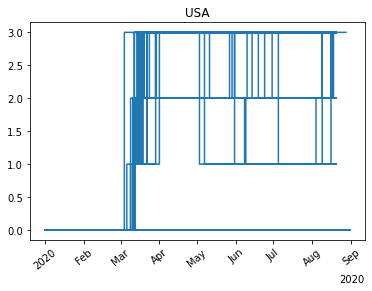

In [26]:
foo = [(dd['Date'],dd['C1_School closing'],dd['C1_Flag']) 
       for dd in oxdat if dd['CountryCode']=='USA']

fmt = '%Y%m%d'
first = 31+22-1
xx = [datetime.datetime.strptime(dd[0],fmt) for dd in foo][first:]
yy = []
for dd in foo[first:]:
    try:
        yy.append(float(dd[1]))
    except:
        yy.append(float('NaN'))


locator = mdates.MonthLocator()
formatter= mdates.ConciseDateFormatter(locator)

fig,ax = plt.subplots(1,1)
ax.step(xx,yy)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
for tick in ax.get_xticklabels():
    tick.set_rotation(40)
plt.title('USA')
plt.show()

Note:  no wildcard data:

In [27]:
foo = [(dd['Date'],dd['CountryCode'],dd['M1_Wildcard']) 
       for dd in oxdat if dd['M1_Wildcard'] != '']

In [28]:
foo

[]

Notes:  
* first version of `datcodes` leaves out all flags (general vs. targeted implementation)
* 2nd version leaves out all variables measured in dollars

In [29]:
datcodes = ['C1_School closing', 'C2_Workplace closing', 
            'C3_Cancel public events', 'C4_Restrictions on gatherings', 
            'C5_Close public transport', 'C6_Stay at home requirements', 
            'C7_Restrictions on internal movement', 'C8_International travel controls', 
            'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures', 
            'E4_International support', 'H1_Public information campaigns', 
            'H2_Testing policy', 'H3_Contact tracing', 
            'H4_Emergency investment in healthcare', 'H5_Investment in vaccines']

datcodes = ['C1_School closing', 'C2_Workplace closing', 
            'C3_Cancel public events', 'C4_Restrictions on gatherings', 
            'C5_Close public transport', 'C6_Stay at home requirements', 
            'C7_Restrictions on internal movement', 'C8_International travel controls', 
            'E1_Income support', 'E2_Debt/contract relief', 
            'H1_Public information campaigns', 
            'H2_Testing policy', 'H3_Contact tracing']



In [30]:
countrycodes = list(set([dd['CountryCode'] for dd in oxdat if Float(dd['ConfirmedCases'])>10000]))
len(countrycodes)

90

In [31]:
countriesox = list(set([dd['CountryName'] for dd in oxdat if Float(dd['ConfirmedCases'])>10000]))

In [32]:
len(countriesox)

90

In [33]:
def Float(x):
    try:
        rtn = float(x)
    except:
        rtn = float('NaN')
    return rtn


In [34]:
datcodes

['C1_School closing',
 'C2_Workplace closing',
 'C3_Cancel public events',
 'C4_Restrictions on gatherings',
 'C5_Close public transport',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C8_International travel controls',
 'E1_Income support',
 'E2_Debt/contract relief',
 'H1_Public information campaigns',
 'H2_Testing policy',
 'H3_Contact tracing']

In [35]:
def get_codedat(countrycode='USA'):
    codedat = []
    foo = [[dd['Date']]+ [Float(dd[c]) for c in datcodes]
           for dd in oxdat if dd['CountryCode']==countrycode]
    return foo
    


In [36]:
get_codedat()

[['20200101', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200102', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200103', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200104', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200105', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200106', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200107', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200108', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200109', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200110', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200111', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200112', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200113', 0.0, 0.0, 0.0, 0.0, 0.0, 0

### Stringency

In [37]:
[x for x in oxdat[0]]

['CountryName',
 'CountryCode',
 'RegionName',
 'RegionCode',
 'Date',
 'C1_School closing',
 'C1_Flag',
 'C2_Workplace closing',
 'C2_Flag',
 'C3_Cancel public events',
 'C3_Flag',
 'C4_Restrictions on gatherings',
 'C4_Flag',
 'C5_Close public transport',
 'C5_Flag',
 'C6_Stay at home requirements',
 'C6_Flag',
 'C7_Restrictions on internal movement',
 'C7_Flag',
 'C8_International travel controls',
 'E1_Income support',
 'E1_Flag',
 'E2_Debt/contract relief',
 'E3_Fiscal measures',
 'E4_International support',
 'H1_Public information campaigns',
 'H1_Flag',
 'H2_Testing policy',
 'H3_Contact tracing',
 'H4_Emergency investment in healthcare',
 'H5_Investment in vaccines',
 'M1_Wildcard',
 'ConfirmedCases',
 'ConfirmedDeaths',
 'StringencyIndex',
 'StringencyIndexForDisplay',
 'StringencyLegacyIndex',
 'StringencyLegacyIndexForDisplay',
 'GovernmentResponseIndex',
 'GovernmentResponseIndexForDisplay',
 'ContainmentHealthIndex',
 'ContainmentHealthIndexForDisplay',
 'EconomicSupportIn

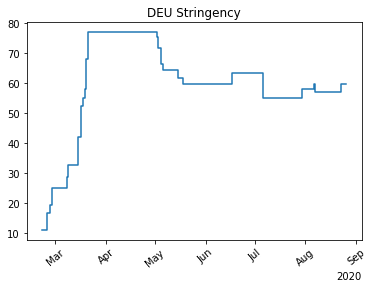

In [38]:
country='DEU'
reg = '' # to get entire country for UK, USA
foo = [(dd['Date'],dd['StringencyIndex'],dd['C1_Flag']) 
       for dd in oxdat if dd['CountryCode']==country and dd['RegionName']==reg]

fmt_ox = '%Y%m%d'
first = 31+22-1  # to get to Feb 22 where data starts
xx = [datetime.datetime.strptime(dd[0],fmt_ox) for dd in foo][first:]
yy = []
for dd in foo[first:]:
    try:
        yy.append(float(dd[1]))
    except:
        yy.append(float('NaN'))


locator = mdates.MonthLocator()
formatter= mdates.ConciseDateFormatter(locator)

fig,ax = plt.subplots(1,1)
ax.step(xx,yy)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
for tick in ax.get_xticklabels():
    tick.set_rotation(40)
plt.title(country+' Stringency')
plt.show()

In [39]:
print("number of countries",len(countrycodes))

number of countries 90


In [40]:
def get_stringency(country,to_database='jhu'):
    global fmt_jhu,fmt_ox,fmt_owid,dates_jhu,dates_owid
    
    stri = [(dd['Date'],dd['StringencyIndex'],dd['C1_Flag']) 
       for dd in oxdat if dd['CountryName']==country and dd['RegionName']=='']
    fmt_ox = '%Y%m%d'
    #first = 31+22-1  # to get to Feb 22 where data starts
    dates_t = [datetime.datetime.strptime(dd[0],fmt_ox) for dd in stri]
    
    if to_database=='jhu':
        fmt = fmt_jhu
        dates = dates_jhu
    elif to_database=='owid':
        fmt = fmt_jhu   # already converted from fmt_owid
        dates = dates_owid
    print('first date',dates[0],'last date',dates[-1])
    firstdate = datetime.datetime.strptime(dates[0],fmt)
    lastdate = datetime.datetime.strptime(dates[-1],fmt)
    ndates=len(dates)
    daystart = (dates_t[0]-firstdate).days
    
    #dates = [date.strftime(fmt_jhu) for date in dates_t]
    yy = np.zeros((lastdate-firstdate).days+1)
    for i,dd in enumerate(stri):
        if daystart+i < len(dates):
            try:
                yy[daystart+i]=float(dd[1])
            except:
                yy[daystart+i]=float('NaN')
    return([dates,yy])
    

first date 1/22/20 last date 8/30/20


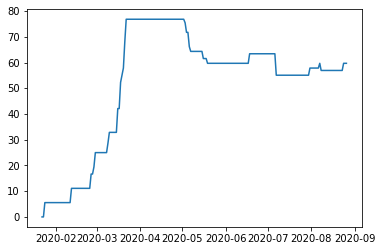

In [41]:
stri = get_stringency('Germany',to_database='jhu')
plt.plot([datetime.datetime.strptime(date,fmt_jhu) for date in stri[0]],stri[1]);

first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20


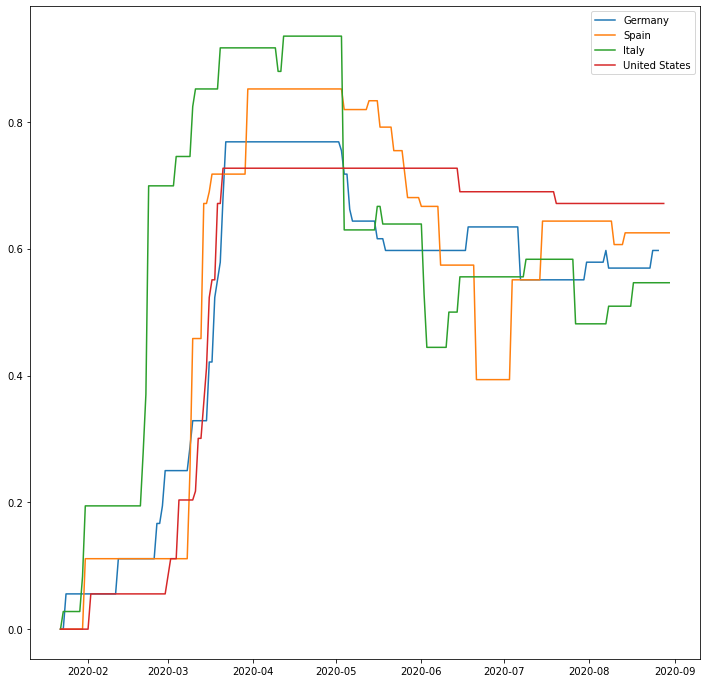

In [42]:
stri = get_stringency('Germany')
datesf = [datetime.datetime.strptime(date,fmt_jhu) for date in stri[0]]
plt.figure(figsize=(12,12))
plt.plot(datesf,np.array(stri[1])/100.,label='Germany');
stri = get_stringency('Spain')
plt.plot(datesf,np.array(stri[1])/100.,label='Spain');
stri = get_stringency('Italy')
plt.plot(datesf,np.array(stri[1])/100.,label='Italy');
stri = get_stringency('United States')
plt.plot(datesf,np.array(stri[1])/100.,label='United States');
plt.legend()

In [43]:
import matplotlib.dates as mdates


first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
f

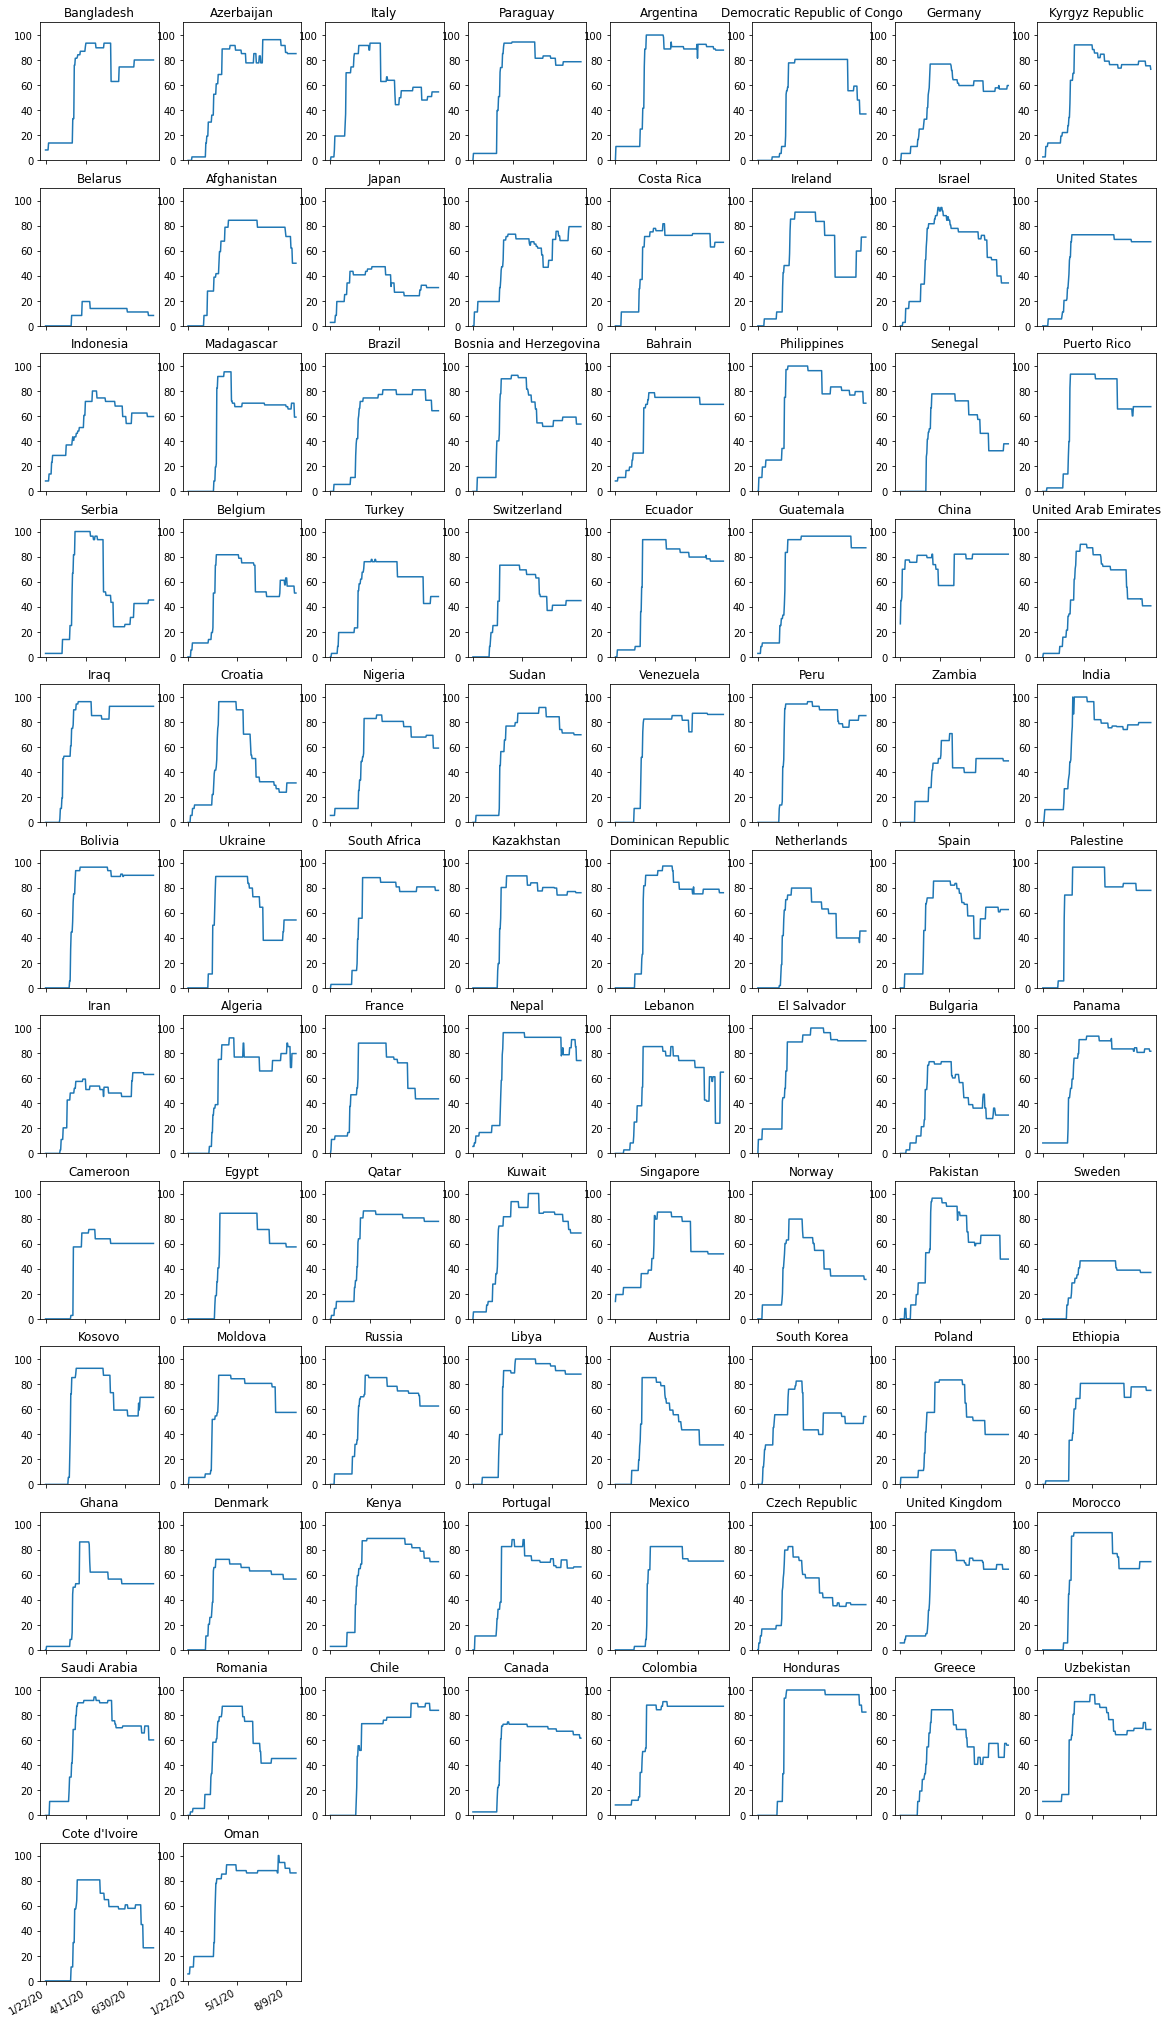

In [44]:
max_rows=12
max_cols=8
idx = 0
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,40))
fig.autofmt_xdate()
for idx, country  in enumerate(countriesox):
    foo = get_stringency(country)
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].set_ylim((0,110))
    axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(3))
    axes[row, col].fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    axes[row, col].plot(foo[0],foo[1])
    axes[row, col].set_title(country)
for idx in range(len(countriesox),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")

In [45]:
len(countriesox)

90

In [46]:
import pickle as pk

In [47]:
dicstringency={}
for cc in countriesox:
    foo = get_stringency(cc)
    dicstringency[cc] = [x[1] for x in foo] # skip date
dates = [x[0] for x in foo]
stringency={}
stringency['dates'] = dates
stringency['data'] = dicstringency
pk.dump(stringency,open('stringency.pk','wb'))

first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
first date 1/22/20 last date 8/30/20
f

## Plots of data for Cautionary Model comparison

Comment out line 1110 in pwlf.py (in /⁨usr⁩/local⁩/lib⁩/⁨python3.7⁩/site-packages⁩/pwlf⁩ directory)
    print("Warning: zero length interval encountered in pwlf.py calc_slopes").  
to remove repeated warnings, which don't seem to harm final result
    Warning: zero length interval encountered in pwlf.py calc_slopes

Parameter type | Parameter value  | Standard error   | t                | P > np.abs(t) (p-value)
Slope          |    -1495.964     |     5391.589     |       -0.277     |        0.782
Slope          |      236.967     |      369.860     |        0.641     |        0.522
Slope          |     3981.764     |      394.981     |       10.081     |        0.000
Slope          |    -3863.300     |      143.420     |      -26.937     |        0.000
Slope          |  -132387.103     |    17323.352     |       -7.642     |        0.000
Breakpoint     |       25.516     |        1.719     |       14.841     |        0.000
Breakpoint     |       75.753     |        1.237     |       61.254     |        0.000
Breakpoint     |      196.037     |        0.182     |     1079.582     |        0.000

Parameter type | Parameter value  | Standard error   | t                | P > np.abs(t) (p-value)
Slope          |   -56517.205     |     6216.412     |       -9.092     |        0.000
Slope          |    

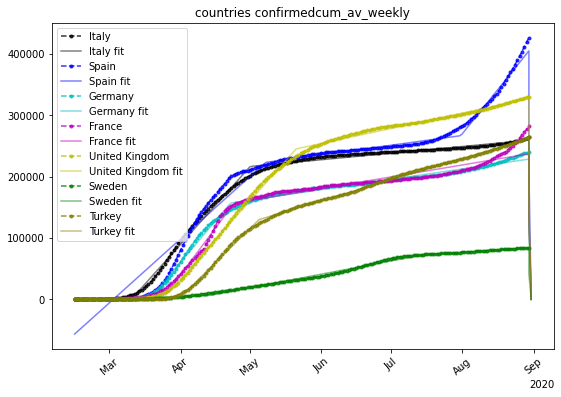

In [48]:
plotCountry_(['Italy','Spain','Germany','France','United Kingdom','Sweden','Turkey'],
             'confirmed','cum_av_weekly',firstdate='02/15/20',lastdate='09/1/20',fittype='piecewise-linear',nsegments=4)
if savefigs:
    plt.savefig("covid-19-caution/figures/fig1a.pdf",bbox_inches='tight')

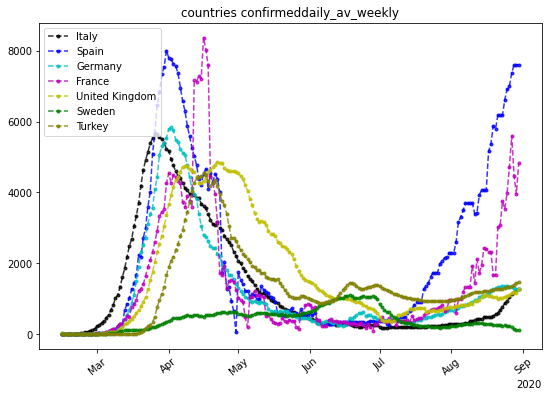

In [49]:
plotCountry_(['Italy','Spain','Germany','France','United Kingdom','Sweden','Turkey'],
            'confirmed','daily_av_weekly',firstdate='02/15/20',lastdate='08/31/20',database='jhu')
if savefigs:
    plt.savefig("covid-19-caution/figures/fig1b.pdf",bbox_inches='tight')

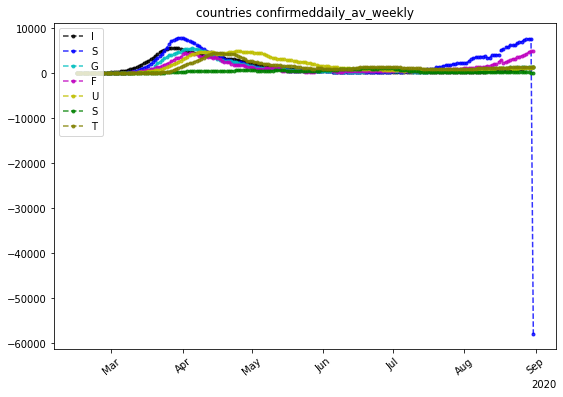

In [50]:
plotCountry_(['Italy','Spain','Germany','France','United Kingdom','Sweden','Turkey'],
            'confirmed','daily_av_weekly',firstdate='02/15/20',lastdate='08/31/20',database='owid')
if savefigs:
    plt.savefig("covid-19-caution/figures/fig1b_owid.pdf",bbox_inches='tight')

# Simulation

Note:  Problem with setting parameters in model.

The DeterministicOde Class method parameters, converts a dictionary or list of tuples of parameters to a dictionary with sympy symbolic keys, not strings.
So attempts to modify parameter values by accessing this dictionary fail. Copying the dictionary, modifying and rewriting also fail.
Instead we store the dictionary of parameters in addition as a dictionary with string keys, under model.params. When we modify these values, they can then be copied back to the parameters method using model.parameters = model.params.

In [51]:
t = np.linspace(0, lastday -1, lastday)
# WARNING WARNING WARNING !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!   still need to fix t updates in models.py

## Plotting for multiple models

In [52]:
count = 0

def difference(datain):
    dataout = np.zeros(np.shape(datain))
    for i in range(1,len(datain)):
        dataout[i,...] = datain[i,...]-datain[i-1,...]
    return dataout
        
def rolling_average(datain,period):
    (tmax,n) = np.shape(datain)
    dataout = np.zeros((tmax,n),dtype=float)
    moving_av = np.zeros(n,dtype=float)
    for k in range(len(datain)):
        if k-period >= 0:
            moving_av[:] = moving_av[:] - datain[k-7,...]
        moving_av[:] = moving_av[:] + datain[k,...]
        dataout[k] = moving_av/min(float(period),float(k+1))
    return dataout

axes = [None]
    
def solveplot(smodels=['SIR','SCIR','SC2IR','SEIR','SCEIR','SC3EIR','SEI3R','SCEI3R','SC3EI3R'],species='EI',tmax=100,summing='daily',averaging='weekly',fitdata = None,scale='linear',plottitle= '',label='',
              newplot = True, gbrcolors=False, figsize = None):
    """
    solve ODEs and plot for set of models indicated
    params: dictionary of simulation parameters
    scale: alternative 'linear' or 'log'
    species alternatives 'all', 'EI', 'confirmed', 'deaths', 'daily confirmed', 'daily deaths'
    plottitle : title for plot
    label : label for curve when called as part of multicurve plot
    newplot : whether to open new plot True/False
    models : list of models to include, default all three of those possible
    """
    global count
    global axes
    global FracConfirmedDet,FracRecoveredDet,FracDeathsDet
    tvec=np.arange(0,tmax,1)
    tvec1 = tvec[1:]

    if not fitdata is None:
        tmaxf = len(fitdata)
        if fitdata.ndim != 2:
            print("error in number of dimensions of array")
        else:
            print("fit data ",np.shape(fitdata))
        tvecf=np.arange(0,tmaxf,1)
        tvecf1 = tvecf[1:]
            
    nmodels = len(smodels)
    nm = 0
    
    count = count+1
    
    if newplot:
        axes = [None]*nmodels 
        if (figsize == None):
            figsize=(nmodels*8,6)
        plt.figure(figsize=figsize)
        # fig, axeslist = plt.subplots(1, nmodels, figsize=(nmodels*8,6))
        
    solns = []    
    for smodel in smodels:
        model = cmodels[smodel]
        nm = nm + 1
        soln = scipy.integrate.odeint(model.ode, model.initial_values[0], tvec[1::])
        #Plot
        # ax = axeslist[nm]
        if axes[nm-1] == None: 
            ax = axes[nm-1] = plt.subplot(1,nmodels,nm)
        else:
            ax = axes[nm-1]
        if scale == 'log': #Plot on log scale
            ax.semilogy()
            ax.set_ylim([0.00000001,1.0])
        if not isinstance(species,list):
            lspecies = [species]
        else:
            lspecies = species
            
        if summing == 'daily':
            ssoln = difference(soln)
            if not fitdata is None:
                sfit = difference(fitdata)
        else:
            ssoln = soln
            if not fitdata is None:
                sfit = fitdata
                
        if averaging == 'weekly':
            srsoln = rolling_average(ssoln,7)
            if not fitdata is None:
                srfit = rolling_average(sfit,7)
        else:
            srsoln = ssoln
            if not fitdata is None:
                srfit = sfit
                
        for species in lspecies:
            if species == 'confirmed':
                suma = np.sum(srsoln[:,model.confirmed],axis=1)
                if not fitdata is None:
                    ax.plot(tvec1,suma,label=label,color='green')
                    fita = srfit[1::,0]/FracConfirmedDet # confirmed cases data, corrected by FracConfirmedDet
                    ax.plot(tvecf1,fita,'o',label=label,color='green')
                else:
                    ax.plot(tvec1,suma,label=label)
            if species == 'recovered':
                suma = np.sum(srsoln[:,model.recovered],axis=1)   
                if not fitdata is None:
                    ax.plot(tvec1,suma,label=label,color='blue')
                    fita = srfit[1::,1]/FracRecoveredDet # recovered cases data, corrected by FracRecoveredDet
                    ax.plot(tvecf1,fita,'o',label=label,color='blue')
                else:
                    ax.plot(tvec1,suma,label=label)
            elif species == 'deaths':
                suma = np.sum(srsoln[:,model.deaths],axis=1)
                if not fitdata is None:
                    ax.plot(tvec1,suma,label=label,color='red')
                    fita = srfit[1::,2]/FracDeathsDet # deaths cases data, corrected by FracDeathsDet
                    ax.plot(tvecf1,fita,'o',label=label,color='red')
                else:
                    ax.plot(tvec1,suma,label=label)
            elif species == 'deaths_x10':
                suma = np.sum(srsoln[:,model.deaths],axis=1)*10
                if not fitdata is None:
                    ax.plot(tvec1,suma,label=label,color='red')
                    fita = srfit[1::,2]*10/FracDeathsDet # deaths cases data, corrected by FracDeathsDet
                    ax.plot(tvecf1,fita,'o',label=label,color='red')
                else:
                    ax.plot(tvec1,suma,label=label)
            elif species == 'EI':
                ax.plot(tvec1,soln[:,model.ei],label=label)
                # ax.plot(tvec1,soln[:,model.ei],label="%s" % count)
                if 'I3' in model.modelname: 
                    plt.legend(("E","I1","I2","I3"))
                elif 'E' in model.modelname: 
                    plt.legend(("E","I"))
                else:
                    plt.legend(("I"))
            elif species == 'caution_fraction':
                #print('model name',model.modelname)
                susc = soln[:,model.S_c]
                suma = np.sum(soln[:,model.all_susceptibles],axis=1)
                old_settings = np.seterr(divide='ignore') #
                suma = np.divide(susc,suma)
                np.seterr(**old_settings)  # reset to default
                if not fitdata is None:
                    ax.plot(tvec1,suma,label=label,color='green')
                    fita = srfit[1::,0] # caution fraction from data
                    ax.plot(tvecf1,fita,'o',label=label,color='green')
                else:
                    ax.plot(tvec1,suma,label=label)               
            elif species == 'all':
                ax.plot(tvec1,soln,label=label)

                if 'I3' in model.modelname:
                    if 'C3'in model.modelname:
                        pspecies=("S","E","I1","I2","I3","R","D","Ic","Sc","Ec")
                    elif 'C' in model.modelname:
                        pspecies=("S","E","I1","I2","I3","R","D","Sc")
                    else:
                        pspecies=("S","E","I1","I2","I3","R","D")
                elif 'E' in model.modelname:
                    if 'C3'in model.modelname:
                        pspecies=("S","E","I","R","D","Ic","Sc","Ec")
                    else:
                        pspecies=("S","E","I","R","D","Sc")                
                else:
                    if 'C2'in model.modelname:
                        pspecies=("S","I","R","D","Ic","Sc")
                    else:
                        pspecies=("S","I","R","D","Sc")
                plt.legend(pspecies)
            
        plt.xlabel("Time (days)")
        plt.ylabel("Fraction of population")
        plt.title(model.modelname +' '+plottitle)
        solns.append(soln)
    return solns

## Simulation of SCIR model

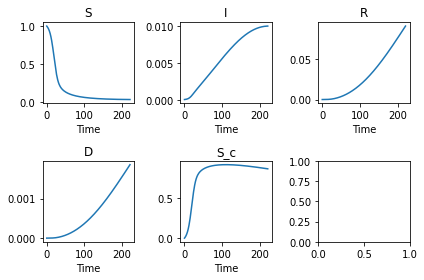

Peak infection (days) 221.0


In [54]:
model = 'SCIR'
solution = cmodels[model].integrate(t[1::])

cmodels[model].plot() # in built pygom plot

# calculate time point when maximum number of people are infectious
peak_i = np.argmax(solution[:,1])
print('Peak infection (days)', t[peak_i])

### Integration and plot using scipy and matplotlib directly

{beta: 0.25, gamma: 0.07106130520764667, mu: 0.0014502307185234006, c_0: 0.3, c_1: 0.07142857142857142, c_2: 200.0, N: 1}
[9.9997e-01 3.0000e-05 0.0000e+00 0.0000e+00 0.0000e+00]


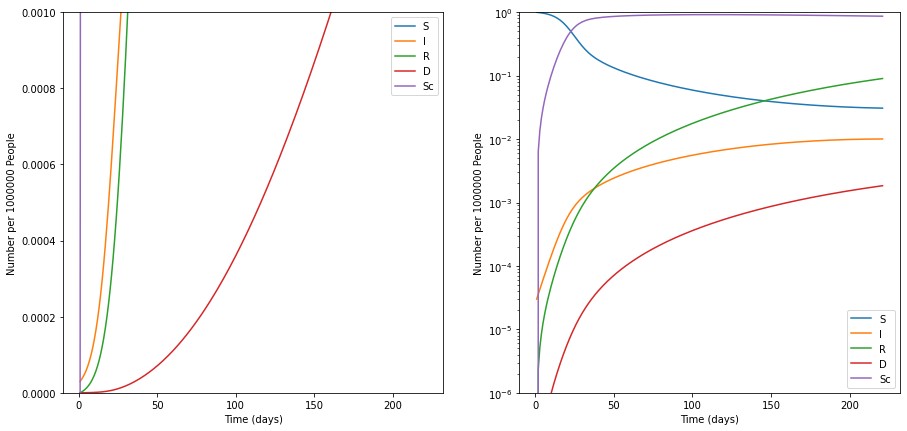

In [59]:
print(cmodels['SCIR'].parameters)
(x0_SCIR,t0) = cmodels['SCIR'].initial_values
print(x0_SCIR)
solution1 = scipy.integrate.odeint(cmodels['SCIR'].ode, x0_SCIR, t[1::])
ys = solution1.copy()
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000000 People")
plt.ylim([0,0.001])
plt.plot(t[1::],ys,label=("S","I","R","D","Sc"))
plt.legend(("S","I","R","D","Sc"))
plt.subplot(1,2,2)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000000 People")
plt.ylim([0.000001,1])
plt.semilogy()
plt.plot(t[1::],ys,label=("S","I","R","D","Sc"))
plt.legend(("S","I","R","D","Sc"));

### Integration and plot using solveplot function (allows multiplot comparisons)

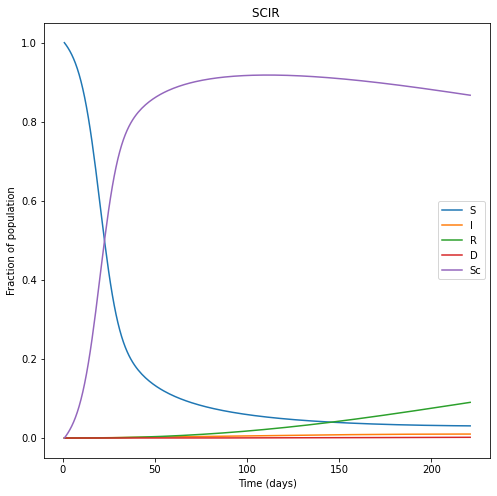

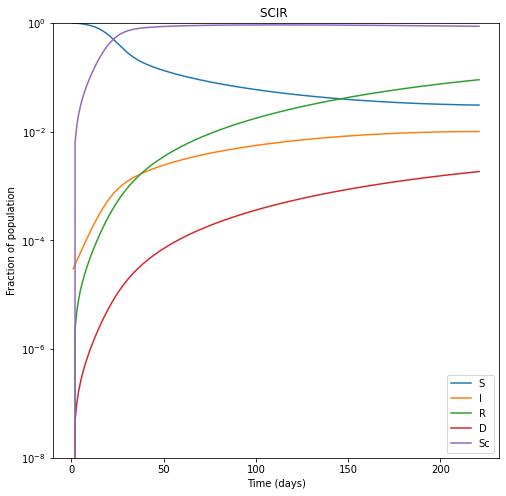

In [60]:
    solveplot(smodels=['SCIR'],species=['all'],tmax=len(t),summing='daily',averaging='weekly',scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (8,8));
    solveplot(smodels=['SCIR'],species=['all'],tmax=len(t),summing='daily',averaging='weekly',scale='log',plottitle= '',label='confirmed',newplot = True, figsize = (8,8));

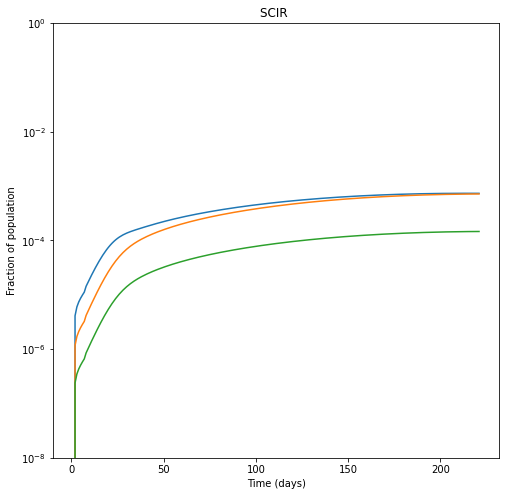

In [61]:
    solveplot(smodels=['SCIR'],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',scale='log',plottitle= '',label='confirmed',newplot = True, figsize = (8,8));

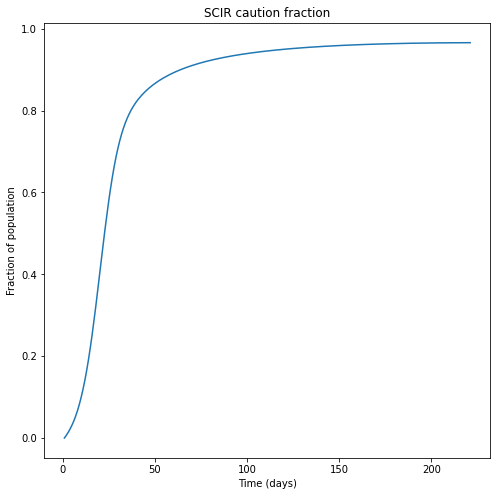

In [62]:
    solveplot(smodels=['SCIR'],species=['caution_fraction'],tmax=len(t),summing=None,averaging=None,scale='linear',plottitle= 'caution fraction',label='caution fraction',newplot = True, figsize = (8,8));

### Compare data with SCIR simulation

parameters {beta: 0.15, gamma: 0.07106130520764667, mu: 0.0014502307185234006, c_0: 0.85, c_1: 0.07142857142857142, c_2: 200.0, N: 1}
initial conditions [9.9997e-01 3.0000e-05 0.0000e+00 0.0000e+00 0.0000e+00]
Peak infection (days) 220.0


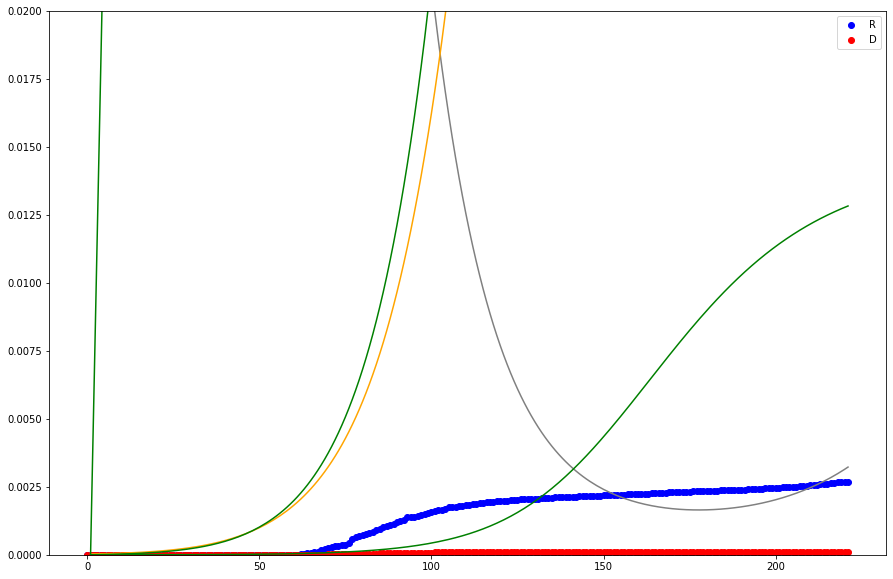

In [63]:
# model with generating parameters 
params1 = SCIR_model.params.copy()
params1['c_0']=0.85
params1['beta']=0.15
SCIR_model.parameters = params1
print('parameters',SCIR_model.parameters)
x0_fit = x0_SCIR.copy()
print('initial conditions',x0_fit)
t_fit = t
SCIR_model.initial_values = (x0_fit, t_fit[0])
sol_fit = scipy.integrate.odeint(SCIR_model.ode, x0_fit, t_fit[1::])
plt.figure(figsize=(15,10))
plt.plot(t,y_jhu[test_country][:,1]/FracRecoveredDet, 'bo',label='R') # recovered
plt.plot(t,y_jhu[test_country][:,2], 'ro',label='D') # died
plt.gca().set_prop_cycle(color=['grey','orange','green','green','green','blue','red', 'black'])
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.02])
plt.legend()
peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

### Stochastic simulation

In [64]:
# make SCIR_modelS
state = ['S', 'I', 'R', 'D', 'S_c']
param_list = ['beta', 'gamma', 'mu', 'c_0', 'c_1', 'c_2', 'N']
transition = [
    Transition(origin='S', destination='I', equation='beta*I*S',
               transition_type=TransitionType.T),
    Transition(origin='S', destination='S_c', equation='c_2*I*S',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='S', equation='c_1*S_c',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='I', equation='c_0*beta*I*S_c',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='R', equation='gamma*I',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='D', equation='mu*I',
               transition_type=TransitionType.T)    
    ]
SCIR_modelS = SimulateOde(state, param_list , transition=transition)


In [65]:
N=10000   # need integer N to allow stochastic simulation. 100000 or more - simulation too slow
I_0 =  10
x0_SCIR_S = [N-I_0, I_0, 0, 0, 0]
# Define parameters based on clinical observations Dr. Alison
Exposure=0.25 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurInf=10 #Duration of mild infections, days
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.05 #Case fatality rate (fraction of infections resulting in death)
TimeDeath=DurInf+7 #Time from ICU admission to death, days

# Model extension by John McCaskill to include caution 
CautionFactor= 0.4 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.25 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.02 # Fraction of ICUs relative to population size N                                                       # increased 10X for low pop simulation

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.125  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0
params_S = {'beta' : Exposure/sum(x0_SCIR_S),
          'gamma': (1.0/DurInf),
          'mu'    : (1.0/TimeDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SCIR_S)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SCIR_S)}
SCIR_modelS.initial_values = (x0_SCIR_S, t[0])
SCIR_modelS.parameters = params_S
SCIR_modelS.params = params_S.copy()
t_jump = np.linspace(0,100,50)
simX, simT =SCIR_modelS.simulate_jump(t_jump, iteration=5, full_output=True)

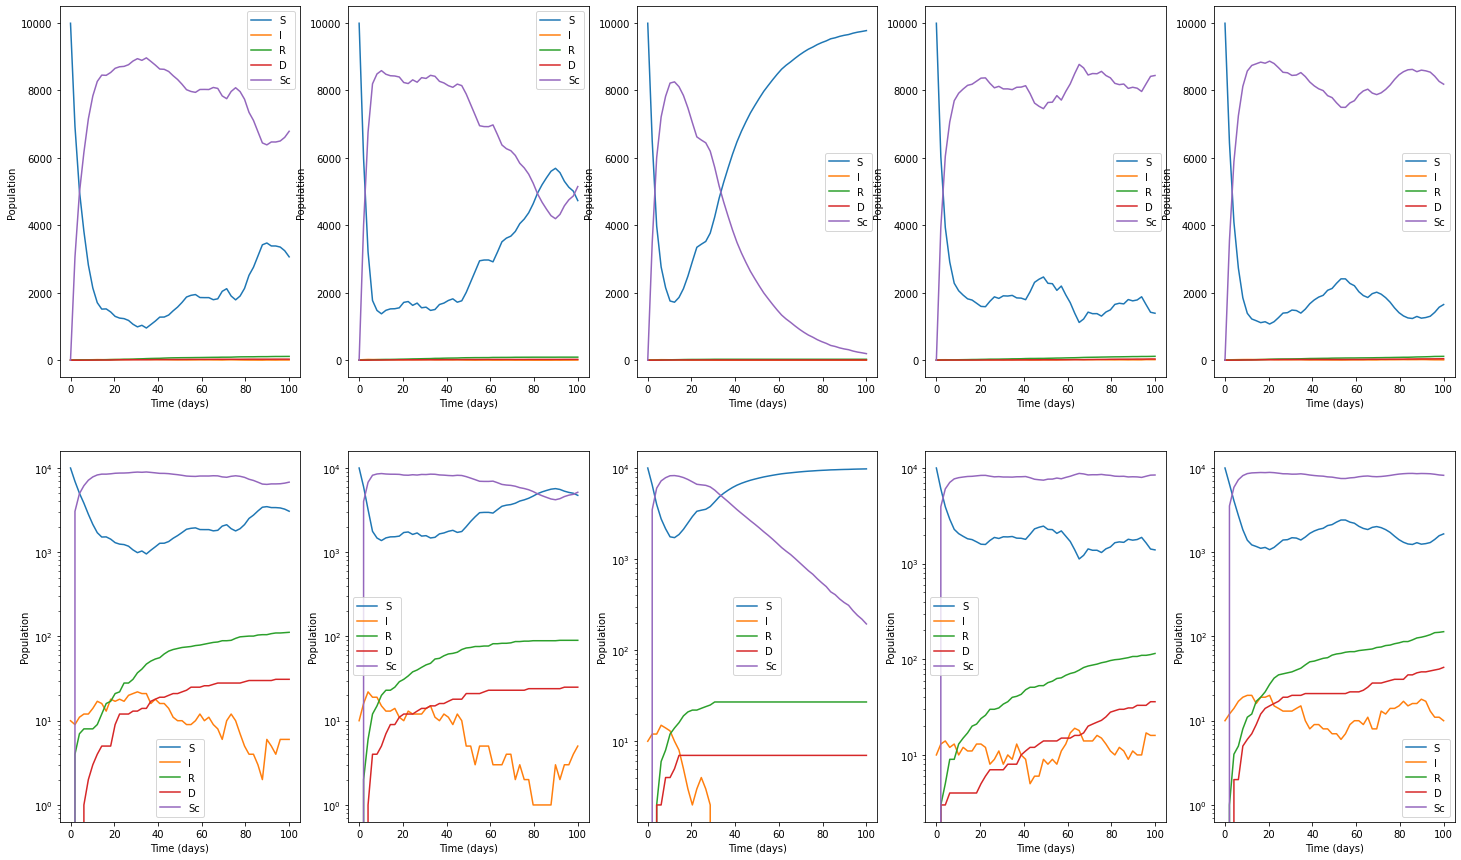

In [66]:
plt.figure(figsize=(25,15))

for iter in range(5):
    plt.subplot(2,5,iter+1)
    plt.xlabel("Time (days)")
    plt.ylabel("Population")
    plt.plot(simT,simX[iter],label=("S","I","R","D","Sc"))
    plt.legend(("S","I","R","D","Sc"))
for iter in range(5):
    plt.subplot(2,5,5+iter+1)
    plt.xlabel("Time (days)")
    plt.ylabel("Population")
    plt.semilogy()
    plt.plot(simT,simX[iter],label=("S","I","R","D","Sc"))
    plt.legend(("S","I","R","D","Sc"));

## Simulation of SC2IR model

In [ ]:
# setup time points for simulation, initial conditions and parameters
t = np.linspace(0, lastday -1, lastday)

# initial conditions assuming there is no natural immunity
I_0 =  0.00003
x0 = [1.0-I_0, I_0, 0.0, 0.0, 0.0, 0.0]

# Define parameters based on clinical observations Dr. Alison
Exposure=0.25 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurInf=10 #Duration of mild infections, days
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.05 #Case fatality rate (fraction of infections resulting in death)
TimeDeath=DurInf+7 #Time from ICU admission to death, days

# Model extension by John McCaskill to include caution 
CautionFactor= 0.4 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.25 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.002 # Fraction of ICUs relative to population size N

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.125  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# convert above parameters to model parameters
params = {'beta' : Exposure/sum(x0),
          'gamma': (1.0/DurInf),
          'mu'    : (1.0/TimeDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0)}
print('parameters',params)
# assign x0 and params to the model, integrate over t and plot
SC2IR_model.initial_values = (x0, t[0])
SC2IR_model.parameters = params
SC2IR_model.params = params.copy()
solution = SC2IR_model.integrate(t[1::])

SC2IR_model.plot()

# calculate time point when maximum number of people are infectious
peak_i = np.argmax(solution[:,1])
print('Peak infection (days)', t[peak_i])

### Integration and plot using scipy and matplotlib directly

In [ ]:
solution1 = scipy.integrate.odeint(SC2IR_model.ode, x0, t[1::])
ys = solution1.copy()
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.xlabel("Time (days)")
plt.ylabel("Fraction of population")
plt.ylim([0,1])
plt.gca().set_prop_cycle(color=['grey','green','blue','red','darkgreen', 'black'])
plt.plot(t[1::],ys,label=("S","I","R","D",'Ic',"Sc"))
plt.legend(("S","I","R","D","Ic","Sc"))
plt.title(SC2IR_model.modelname)
plt.subplot(1,2,2)
plt.xlabel("Time (days)")
plt.ylabel("Fraction of population")
plt.ylim([0.000001,1])
plt.semilogy()
plt.gca().set_prop_cycle(color=['grey','green','blue','red','darkgreen', 'black'])
plt.plot(t[1::],ys,label=("S","I","R","D",'Ic',"Sc"))
plt.legend(("S","I","R","D","Ic","Sc"))
plt.title(SC2IR_model.modelname + ' - semilog');

### Compare data with SC2IR simulation

In [ ]:
# model with generating parameters 
def isolveplot(beta,gamma,mu,c_0,c_1,c_2,logI_0):
    # saveparams=SC2IR_model.parameters.copy() # backup model current parameters
    # saveICs = SC2IR_model.initial_values # back model ICs
    I_0 = 10.**logI_0
    x0 = [1.0-I_0, I_0, 0.0, 0.0, 0.0, 0.0]
    params = {'beta' : beta,
          'gamma': gamma,
          'mu'    : mu,
          'c_0'    : c_0,
          'c_1'    : c_1,
          'c_2'    : c_2,
          'N'     : sum(x0)}
    SC2IR_model.initial_values = (x0, t[0])
    SC2IR_model.parameters = params.copy()
    
    sol_fit = scipy.integrate.odeint(SC2IR_model.ode, x0, t[1::])
    #
    plt.figure(figsize=(15,10))
    plt.plot(t,y_jhu[test_country][:,1]/FracRecoveredDet, 'bo',label='R') # recovered
    plt.semilogy()
    plt.plot(t,y_jhu[test_country][:,2], 'ro',label='D') # died
    plt.semilogy()
    plt.gca().set_prop_cycle(color=['grey','green','blue','red','darkgreen','black'])
    plt.plot(t[1::], sol_fit)
    plt.ylim([0.000001,1])
    plt.semilogy()
    plt.legend(('R','D','S','I','R','D','I_c','S_c'))
    #plt.show(())
    #ode_fit.plot()

    peak_i = np.argmax(sol_fit[:,2])
    print('Peak infection (days)', t_fit[peak_i])
    # SC2IR_model.parameters=saveparams.copy()
    # SC2IR_model.initial_values=saveICs

In [ ]:
params = {'beta' : 0.25,
          'gamma': 0.1,
          'mu'    : 0.05,
          'c_0'    : 0.3,
          'c_1'    : 1./14.,
          'c_2'    : 2000.,
          'N'     : 1.}
interact(isolveplot,
         beta=FloatSlider(min=0,max=1,step=0.01,value=params['beta'],description='beta',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         gamma=FloatSlider(min=0,max=1,step=0.01,value=params['gamma'],description='gamma',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.1,step=0.001,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
#         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=np.log10(x0[1]),description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False))

In [ ]:
slide_params=SC2IR_model.parameters.copy()
print(slide_params)
theta = [0.4,0.11,0.007,0.33,0.228,275.]

## Simulation of SCEI3R model

In [ ]:
# setup time points for simulation, initial conditions and parameters
t = np.linspace(0, lastday -1, lastday)

# initial conditions assuming there is no natural immunity
E_0 =  0.00003
x0_SCEI3R = [1.0-E_0, E_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Define parameters based on clinical observations Dr. Alison
Exposure=0.25 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=10 #Duration of mild infections, days
FracMild=0.70  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.07 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=7 #Time from ICU admission to death, days
DurHosp=11 #Duration of hospitalization, days

# Model extension by John McCaskill to include caution 
CautionFactor= 0.2 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.3 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.002 # Fraction of ICUs relative to population size N

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.125  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# convert above parameters to model parameters
params = {'beta_1' : Exposure/sum(x0_SCEI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SCEI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SCEI3R)}
print(params)
# assign x0 and params to the model, integrate over t and plot
SCEI3R_model.initial_values = (x0_SCEI3R, t[0])
SCEI3R_model.parameters = params
SCEI3R_model.params = params.copy()
solution = SCEI3R_model.integrate(t[1::])

SCEI3R_model.plot()

# calculate time point when maximum number of people are infectious
peak_i = np.argmax(solution[:,2])
print('Peak infection (days)', t[peak_i])

### Compare data with SCEI3R simulation

In [ ]:
# model with generating parameters 
params1 = SCEI3R_model.params.copy()
params1['c_0']=0.7
SCEI3R_model.parameters = params1
print(SCEI3R_model.parameters)
x0_fit = x0_SCEI3R.copy()
# x0_fit[2] = 0.00001
#t_fit = numpy.linspace(0, 150, 1000)
print(x0_fit)
t_fit = t
print(len(t))
SCEI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
#sol_fit =SCEI3R_model.integrate(t_fit[1::])
# sol_fit = SCEI3R_model.integrate(t_fit)
sol_fit = scipy.integrate.odeint(SCEI3R_model.ode, x0_fit, t_fit[1::])
# print(len(sol_fit[0]))
#
plt.figure(figsize=(15,10))
#plt.plot(t,y_jhu[test_country][:,0], 'go',label='I_1') # infected observations
#plt.plot(t,y_jhu[test_country][:,1], 'go',label='I_2') # infected observations
#plt.plot(t,y_jhu[test_country][:,2], 'go',label='I_3') # infected observations
plt.plot(t,y_jhu[test_country][:,1]/FracRecoveredDet, 'bo',label='R') # recovered
plt.plot(t,y_jhu[test_country][:,2], 'ro',label='D') # died
plt.gca().set_prop_cycle(color=['grey','orange','green','green','green','blue','red','black',])
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.06])
plt.legend()
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

### Integration and plot using scipy and matplotlib directly

In [ ]:
# solution = scipy.integrate.odeint(SCEI3R_model.ode, x0, t)
# print(len(t))
solution1 = scipy.integrate.odeint(SCEI3R_model.ode, x0_SCEI3R, t[1::])
ys = solution1.copy()
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000000 People")
plt.ylim([0,1])
plt.legend(("S","E","I1","I2","I3","R","D","Sc"))
plt.plot(t[1::],ys)
plt.subplot(1,2,2)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000000 People")
plt.ylim([0.000001,1])
plt.legend(("S","E","I1","I2","I3","R","D","Sc"))
plt.semilogy()
plt.plot(t[1::],ys);

## Simulation of SC3EI3R model

In [ ]:
len(params)

In [ ]:
# setup time points for simulation, initial conditions and parameters
t = np.linspace(0, lastday -1, lastday)
tmax=lastday-1
# initial conditions assuming there is no natural immunity
E_0 =  0.00003
x0_SC3EI3R = [1.0-E_0, E_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# Define parameters based on clinical observations Dr. Alison
Exposure=0.25 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=10 #Duration of mild infections, days
FracMild=0.70  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.07 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=7 #Time from ICU admission to death, days
DurHosp=11 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.125  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.2 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.3 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.002 # Fraction of ICUs relative to population size N


# convert above parameters to model parameters
params = {'beta_1' : Exposure/sum(x0_SC3EI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3EI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SC3EI3R)}

print(params)
# assign x0 and params to the model, integrate over t and plot
SC3EI3R_model.initial_values = (x0_SC3EI3R, t[0])
SC3EI3R_model.parameters = params
SC3EI3R_model.params = params.copy()
solution = SC3EI3R_model.integrate(t[1::])

SC3EI3R_model.plot()

# calculate time point when maximum number of people are infectious
peak_i = np.argmax(solution[:,2])
print('Peak infection (days)', t[peak_i])

### Compare data with SC3EI3R simulation

In [ ]:
# model with generating parameters 
params1 = SC3EI3R_model.params.copy()
params1['c_0']=0.35
SC3EI3R_model.parameters = params1
print(SC3EI3R_model.parameters)
x0_fit = x0_SC3EI3R.copy()
# x0_fit[2] = 0.00001
#t_fit = numpy.linspace(0, 150, 1000)
print(x0_fit)
t_fit = t
print(len(t))
SC3EI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SC3EI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
sol_fit =SC3EI3R_model.integrate(t_fit[1::])
# sol_fit = SC3EI3R_model.integrate(t_fit)
# sol_fit = scipy.integrate.odeint(SC3EI3R_model(params_fit).ode, x0_fit, t_fit[1::])
# print(len(sol_fit[0]))
#
plt.figure(figsize=(15,10))
plt.plot(t,y_jhu[test_country][:,1]/FracRecoveredDet, 'bo',label='R') # recovered
plt.plot(t,y_jhu[test_country][:,2]/FracDeathsDet, 'ro',label='D') # died
plt.gca().set_prop_cycle(color=['grey','orange','green','green','green','blue','red','darkgreen', 'black'])
#plt.plot(t_fit[1::], sol_fit)
plt.plot(t_fit, sol_fit)
plt.ylim([0,0.06])
plt.legend()
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

### Compare stringency data with SC3EI3R simulation caution fraction

In [ ]:
plt.figure(figsize=(12,12))
foo = get_stringency('Germany')
datesf = [datetime.datetime.strptime(date,fmt_jhu) for date in foo[0]]
plt.plot(datesf,np.array(foo[1])/100.,label='Germany');
foo = get_stringency('Spain')
plt.plot(datesf,np.array(foo[1])/100.,label='Spain');
foo = get_stringency('Italy')
plt.plot(datesf,np.array(foo[1])/100.,label='Italy');
foo = get_stringency('United States')
plt.plot(datesf,np.array(foo[1])/100.,label='United States');
plt.legend()
solveplot(smodels=['SC3EI3R'],species=['caution_fraction'],tmax=len(t),summing='daily',averaging='weekly',scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (12,12));

## Simulation models for range of caution parameters

### Reinitialize multimodel consistent sets of parameters

In [ ]:
# Set up multimodel consistent sets of parameters
Exposure=0.25     # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5     # Incubation period, days 
DurMildInf=10     # Duration of mild infections, days
FracMild=0.8      # Fraction of infections that are mild
FracSevere=0.15   # Fraction of infections that are severe
FracCritical=0.05 # Fraction of infections that are critical
CFR=0.02          # Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=7    # Time from ICU admission to death, days
DurHosp=11        # Duration of hospitalization, days

# Model extension by John McCaskill to include caution 
CautionFactor= 0.3    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 14. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.25  # Fraction of ICUs occupied leading to 90% of susceptibles in caution 
ICUFrac= 0.001        # Fraction of ICUs relative to population size N

EconomicCostOfCaution = 0.5 # Cost to economy of individual exercising caution

N=1
b=np.zeros(4)     # beta
g=np.zeros(4)     # gamma
p=np.zeros(3)     # progression
c=np.zeros(3)     # caution
k=np.zeros(4)     # economic caution

a=1/IncubPeriod                       # transition rate from exposed to infected
b=Exposure*np.array([0,1,0,0])/N      # hospitalized cases don't transmit
u=(1/TimeICUDeath)*(CFR/FracCritical) # death rate from ICU
g[3]=(1/TimeICUDeath)-u               # recovery rate

p[2]=(1/DurHosp)*(FracCritical/(FracCritical+FracSevere))
g[2]=(1/DurHosp)-p[2]

g[1]=(1/DurMildInf)*FracMild
p[1]=(1/DurMildInf)-g[1]

c[0]=CautionFactor
c[1]=1/CautionRetention
c[2]=1/(N*ICUFrac*CautionICUFrac)     # this is the rate coefficient giving 1/day at I3 = denominator

k[0]=c[1]
k[1]=c[1]
k[2]=c[1]
k[3]=EconomicCostOfCaution

cmodels = {'SIR':SIR_model,'SCIR':SCIR_model,'SC2IR':SC2IR_model,
           'SEIR':SEIR_model,'SCEIR':SCEIR_model,'SC3EIR':SC3EIR_model,
           'SEI3R':SEI3R_model,'SCEI3R':SCEI3R_model,'SC3EI3R':SC3EI3R_model,
           'SC2UIR':SC2UIR_model,'SC3UEIR':SC3UEIR_model,'SC3UEI3R':SC3UEI3R_model}
smodels = ['SIR','SCIR','SC2IR','SEIR','SCEIR','SC3EIR','SEI3R','SCEI3R','SC3EI3R','SC2UIR','SC3UEIR','SC3UEI3R']

for smodel in smodels: 
    params_in=vector2params(b,a,g,p,u,c,k,N,FracCritical,smodel)
    # print(smodel,params_in)
    cmodels[smodel].parameters = params_in

t = np.linspace(0, lastday -1, lastday)
I_0 =  0.00003

x0_SIR = [1.0-I_0, I_0, 0.0, 0.0]
x0_SCIR = [1.0-I_0, I_0, 0.0, 0.0, 0.0]
x0_SC2IR = [1.0-I_0, I_0, 0.0, 0.0, 0.0, 0.0]
SIR_model.initial_values = (x0_SIR, t[0])
SCIR_model.initial_values = (x0_SCIR, t[0])
SC2IR_model.initial_values = (x0_SC2IR, t[0])

x0_SEIR = [1.0-I_0, 0.0, I_0, 0.0, 0.0]
x0_SCEIR = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0]
x0_SC3EIR = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0]
SEIR_model.initial_values = (x0_SEIR, t[0])
SCEIR_model.initial_values = (x0_SCEIR, t[0])
SC3EIR_model.initial_values = (x0_SC3EIR, t[0])

x0_SEI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0]
x0_SCEI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0]
x0_SC3EI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
SEI3R_model.initial_values = (x0_SEI3R, t[0])
SCEI3R_model.initial_values = (x0_SCEI3R, t[0])
SC3EI3R_model.initial_values = (x0_SC3EI3R, t[0])


x0_SC2UIR = [1.0-I_0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
x0_SC3UEIR = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
x0_SC3UEI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
SC2UIR_model.initial_values = (x0_SC2UIR, t[0])
SC3UEIR_model.initial_values = (x0_SC3UEIR, t[0])
SC3UEI3R_model.initial_values = (x0_SC3UEI3R, t[0])

### Comparison of SIR, SEIR and SEI3R with full caution extensions SC2IR, SC3EIR, SC3EI3R

In [ ]:
smodels1 = ['SIR','SEIR','SEI3R']
smodels2 = ['SC2IR','SC3EIR','SC3EI3R']
# tmax = lastday-1
tmax = 300
# caution standard parameters
CautionFactor= 0.2    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.3   # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.002        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [1.0,0.9,0.8,0.7,0.6,0.5]   # Fractional reduction of exposure rate for cautioned individuals
CautionFactors2= [0.5,0.4,0.3,0.2,0.1,0.0]     # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,14.,28.,56.,112.,224.]      # Duration of cautionary state of susceptibles
CautionICUFracs= [1.0,0.75,0.5,0.25,0.125,0.0625] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 

import os
cwd=os.getcwd()

newplot = True  
for smodel in smodels1:
    model = cmodels[smodel]
label_c = '' 
plottitle = 'Without Caution' 
solns=solveplot(smodels1,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)

irat = 1 + p[1]/(g[2]+p[2]) + p[2]/(g[3]+u)
drat = (p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u))/irat

newplot = True
for s in range(6):
    for smodel in smodels2:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactors[s],'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
                
    label_c = 'CautionFactor %s' % CautionFactors[s]
    plottitle = 'Caution Factor' 
    solns=solveplot(smodels2,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False  
if savefigs:
    plt.savefig(cwd+"/figures/fig3a.pdf",bbox_inches='tight')

newplot = True
for s in range(6):
    for smodel in smodels2:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactors2[s],'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
                
    label_c = 'CautionFactor %s' % CautionFactors2[s]
    plottitle = 'Caution Factor' 
    solns=solveplot(smodels2,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False  
if savefigs:
    plt.savefig(cwd+"/figures/fig3b.pdf",bbox_inches='tight')

newplot = True
#for i in reversed(range(5)):
for s in range(6):
    for smodel in smodels2:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s]}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionRetention %s'% CautionRetentions[s]
    plottitle = 'Caution Retention' 
    solns=solveplot(smodels2,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False
if savefigs:
    plt.savefig(cwd+"/figures/fig3c.pdf",bbox_inches='tight')

newplot = True    
for s in range(6):
    for smodel in smodels2:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s]}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFracs[s])}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFracs[s])}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFracs[s])}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionICUFrac %s'% CautionICUFracs[s]
    plottitle = 'Caution ICUFrac' 
    solns=solveplot(smodels2,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False
if savefigs:
    plt.savefig(cwd+"/figures/fig3d.pdf",bbox_inches='tight')

# return parameters to standard set
for smodel in smodels2:
    model = cmodels[smodel]
    if 'C' in model.modelname:
        cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}
        


### Comparison of simple and full caution extensions:

#### SCEIR, SCEI3R vs SC3EIR,SC3EI3R: confirmed

In [ ]:
smodels = ['SCEIR','SC3EIR','SCEI3R','SC3EI3R']
# tmax = lastday-1
tmax = 300
# caution standard parameters
CautionFactor= 0.25    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 45. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.05   # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.002        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [1.0,0.9,0.75,0.5,0.25,0.0]   # Fractional reduction of exposure rate for cautioned individuals
CautionFactors2= [0.4,0.3,0.2,0.1,0.0]   # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,14.,28.,56.,112.,224.]      # Duration of cautionary state of susceptibles
CautionICUFracs= [1.0,0.75,0.5,0.25,0.125,0.0625] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 

newplot = True
for s in range(6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            if 'E' in model.modelname:
                cmodels[smodel].parameters = {'c_0':CautionFactors[s],'c_1':1./CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}
            else:
                cmodels[smodel].parameters = {'c_0':CautionFactors[s],'c_1':1./CautionRetention,'c_2':FracSevere*FracCritical/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
        else:
            print("ERROR")
    label_c = 'CautionFactor %s' % CautionFactors[s]
    plottitle = 'Caution Factor' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False

newplot = True
for s in range(5):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            if 'E' in model.modelname:
                cmodels[smodel].parameters = {'c_0':CautionFactors2[s],'c_1':1./CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}
            else:
                cmodels[smodel].parameters = {'c_0':CautionFactors2[s],'c_1':1./CautionRetention,'c_2':FracSevere*FracCritical/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
        else:
            print("ERROR")
    label_c = 'CautionFactor %s' % CautionFactors2[s]
    plottitle = 'Caution Factor' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False
    
newplot = True
#for i in reversed(range(5)):
for s in range(5):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            if 'E' in model.modelname:
                cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s],'c_2':1./(N*ICUFrac*CautionICUFrac)}
            else:
                cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s],'c_2':FracSevere*FracCritical/(N*ICUFrac*CautionICUFrac)}
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetentions[s],'c_2':1./(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionRetention %s'% CautionRetentions[s]
    plottitle = 'Caution Retention' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False

newplot = True    
for s in range(5):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFracs[s])}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionICUFrac %s'% CautionICUFracs[s]
    plottitle = 'Caution ICUFrac' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False
    
# return parameters to standard set
for smodel in smodels:
    model = cmodels[smodel]
    if 'C' in model.modelname:
        cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}

#### SCEIR, SCEI3R vs SC3EIR, SC3EI3R: caution fraction

In [ ]:
# caution_fraction
smodels = ['SCEIR','SC3EIR','SCEI3R','SC3EI3R']
# tmax = lastday-1
tmax = 300
# caution standard parameters
CautionFactor= 0.25    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 45. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.05   # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.002        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [1.0,0.9,0.75,0.5,0.25,0.0]   # Fractional reduction of exposure rate for cautioned individuals
CautionFactors2= [0.4,0.3,0.2,0.1,0.0]   # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,14.,28.,56.,112.,224.]      # Duration of cautionary state of susceptibles
CautionICUFracs= [1.0,0.75,0.5,0.25,0.125,0.0625] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 

newplot = True
for s in range(6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            if 'E' in model.modelname:
                cmodels[smodel].parameters = {'c_0':CautionFactors[s],'c_1':1./CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}
            else:
                cmodels[smodel].parameters = {'c_0':CautionFactors[s],'c_1':1./CautionRetention,'c_2':FracSevere*FracCritical/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
        else:
            print("ERROR")
    label_c = 'CautionFactor %s' % CautionFactors[s]
    plottitle = 'Caution Factor' 
    solns=solveplot(smodels,'caution_fraction',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False

newplot = True
for s in range(5):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            if 'E' in model.modelname:
                cmodels[smodel].parameters = {'c_0':CautionFactors2[s],'c_1':1./CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}
            else:
                cmodels[smodel].parameters = {'c_0':CautionFactors2[s],'c_1':1./CautionRetention,'c_2':FracSevere*FracCritical/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
        else:
            print("ERROR")
    label_c = 'CautionFactor %s' % CautionFactors2[s]
    plottitle = 'Caution Factor' 
    solns=solveplot(smodels,'caution_fraction',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False
    
newplot = True
#for i in reversed(range(5)):
for s in range(5):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            if 'E' in model.modelname:
                cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s],'c_2':1./(N*ICUFrac*CautionICUFrac)}
            else:
                cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s],'c_2':FracSevere*FracCritical/(N*ICUFrac*CautionICUFrac)}
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetentions[s],'c_2':1./(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionRetention %s'% CautionRetentions[s]
    plottitle = 'Caution Retention' 
    solns=solveplot(smodels,'caution_fraction',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False

newplot = True    
for s in range(5):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFracs[s])}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionICUFrac %s'% CautionICUFracs[s]
    plottitle = 'Caution ICUFrac' 
    solns=solveplot(smodels,'caution_fraction',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False
    
# return parameters to standard set
for smodel in smodels:
    model = cmodels[smodel]
    if 'C' in model.modelname:
        cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}

#### SCIR, SCEIR, SCEI3R   vs    SC2IR, SC3EIR, SC3EI3R

In [ ]:
smodels = ['SCIR','SC2IR','SCEIR','SC3EIR','SCEI3R','SC3EI3R']
# tmax = lastday-1
tmax = 300
# caution standard parameters
CautionFactor= 0.2    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.3   # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.002        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [1.0,0.9,0.8,0.7,0.6,0.5]         # Fractional reduction of exposure rate for cautioned individuals
CautionFactors2= [0.5,0.4,0.3,0.2,0.1,0.0]        # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,14.,28.,56.,112.,224.]     # Duration of cautionary state of susceptibles
CautionICUFracs= [1.0,0.75,0.5,0.25,0.125,0.0625] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 

irat = 1 + p[1]/(g[2]+p[2]) + p[2]/(g[3]+u)
drat = (p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u))/irat

newplot = True
for s in range(6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactors[s],'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
                
    label_c = 'CautionFactor %s' % CautionFactors[s]
    plottitle = 'Caution Factor' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False  
if savefigs:
    plt.savefig(cwd+"/figures/fig3sa.pdf",bbox_inches='tight')

newplot = True
for s in range(6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactors2[s],'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
                
    label_c = 'CautionFactor %s' % CautionFactors2[s]
    plottitle = 'Caution Factor' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False  
if savefigs:
    plt.savefig(cwd+"/figures/fig3sb.pdf",bbox_inches='tight')

newplot = True
for s in range(6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s]}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionRetention %s'% CautionRetentions[s]
    plottitle = 'Caution Retention' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False
if savefigs:
    plt.savefig(cwd+"/figures/fig3sc.pdf",bbox_inches='tight')

newplot = True    
for s in range(6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s]}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFracs[s])}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFracs[s])}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFracs[s])}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionICUFrac %s'% CautionICUFracs[s]
    plottitle = 'Caution ICUFrac' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False

if savefigs:
    plt.savefig(cwd+"/figures/fig3sd.pdf",bbox_inches='tight')

# return parameters to standard set
for smodel in smodels:
    model = cmodels[smodel]
    if 'C' in model.modelname:
        cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}

### Comparison of caution SC... with economic coupled caution SCU... models

#### SC2UIR, SC3UEIR  and SC3UEI3R: confirmed

In [ ]:
smodels = ['SC2UIR','SC3UEIR','SC3UEI3R']
# tmax = lastday-1
tmax = 300
# caution standard parameters
CautionFactor= 0.4    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.3   # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.002        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [1.0,0.9,0.8,0.7,0.6,0.5]         # Fractional reduction of exposure rate for cautioned individuals
CautionFactors2= [0.5,0.4,0.3,0.2,0.1,0.0]        # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,14.,28.,56.,112.,224.].reverse()     # Duration of cautionary state of susceptibles
CautionICUFracs= [1.0,0.75,0.5,0.25,0.125,0.0625] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 
ktime = 56.
ktimes= [1., 7.,14.,28.,56.,112.]   # Duration of cautionary state of susceptibles
kappas = [1.,0.8,0.6,0.4,0.2,0.]    # Economic cost of caution
kappa = 0.5
irat = 1 + p[1]/(g[2]+p[2]) + p[2]/(g[3]+u)
drat = (p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u))/irat  

newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktime,'k_w':1./ktime,'kappa':kappas[s]}          
    if s == -1:
        label_c = 'no economic influence'
    else:
        label_c = 'kappa %s' % kappas[s]
    plottitle = 'Cost of caution kappa' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False 
if savefigs:
    plt.savefig(cwd+"/figures/fig5sa.pdf",bbox_inches='tight')

newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktimes[s],'k_1':1./ktime,'k_w':1./ktime, 'kappa':kappa}           
    if s == -1:
        label_c = 'no economic influence'
    else:
        label_c = 'k_u time %s' % ktimes[s]
    plottitle = 'Uncautionable decay k_u' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False     
if savefigs:
    plt.savefig(cwd+"/figures/fig5sb.pdf",bbox_inches='tight')
    
newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktimes[s],'k_w':1./ktime, 'kappa':kappa}          
    if s == -1:
        label_c = 'no economic influence'
    else:
        label_c = 'k_1 time %s' % ktimes[s]
    plottitle = 'Uncautionable decay k_1' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False   
if savefigs:
    plt.savefig(cwd+"/figures/fig5sc.pdf",bbox_inches='tight')
    
newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktime,'k_w':1./ktimes[s], 'kappa':kappa}  
    if s == -1:
        label_c = 'no economic influence'
    else:        
        label_c = 'k_w time %s' % ktimes[s]
    plottitle = 'Economic relaxation k_w' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False    
if savefigs:
    plt.savefig(cwd+"/figures/fig5sd.pdf",bbox_inches='tight')
    
# return parameters to standard set
for smodel in smodels:
    model = cmodels[smodel]
    if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
    if 'U' in model.modelname:
            cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktime,'k_w':1./ktime, 'kappa':kappa}

#### SC2UIR, SC3UEIR  and SC3UEI3R: caution fraction

In [ ]:
#'caution_fraction'
# smodels = ['SC2IR','SC2UIR','SC3EIR','SC3UEIR','SC3EI3R','SC3UEI3R']
smodels = ['SC2UIR','SC3UEIR','SC3UEI3R']
# tmax = lastday-1
tmax = 300
# caution standard parameters
CautionFactor= 0.4    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.3   # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.002        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [1.0,0.9,0.8,0.7,0.6,0.5]         # Fractional reduction of exposure rate for cautioned individuals
CautionFactors2= [0.5,0.4,0.3,0.2,0.1,0.0]        # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,14.,28.,56.,112.,224.].reverse()     # Duration of cautionary state of susceptibles
CautionICUFracs= [1.0,0.75,0.5,0.25,0.125,0.0625] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 
ktime = 56.
ktimes= [1., 7.,14.,28.,56.,112.]   # Duration of cautionary state of susceptibles
kappas = [1.,0.8,0.6,0.4,0.2,0.]    # Economic cost of caution
kappa = 0.5
irat = 1 + p[1]/(g[2]+p[2]) + p[2]/(g[3]+u)
drat = (p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u))/irat  

newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktime,'k_w':1./ktime,'kappa':kappas[s]}          
    if s == -1:
        label_c = 'no economic influence'
    else:
        label_c = 'kappa %s' % kappas[s]
    plottitle = 'Cost of caution kappa' 
    solns=solveplot(smodels,'caution_fraction',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False 
if savefigs:
    plt.savefig(cwd+"/figures/fig5sca.pdf",bbox_inches='tight')

newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktimes[s],'k_1':1./ktime,'k_w':1./ktime, 'kappa':kappa}           
    if s == -1:
        label_c = 'no economic influence'
    else:
        label_c = 'k_u time %s' % ktimes[s]
    plottitle = 'Uncautionable decay k_u' 
    solns=solveplot(smodels,'caution_fraction',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False     
if savefigs:
    plt.savefig(cwd+"/figures/fig5scb.pdf",bbox_inches='tight')
    
newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktimes[s],'k_w':1./ktime, 'kappa':kappa}          
    if s == -1:
        label_c = 'no economic influence'
    else:
        label_c = 'k_1 time %s' % ktimes[s]
    plottitle = 'Uncautionable decay k_1' 
    solns=solveplot(smodels,'caution_fraction',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False   
if savefigs:
    plt.savefig(cwd+"/figures/fig5scc.pdf",bbox_inches='tight')
    
newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktime,'k_w':1./ktimes[s], 'kappa':kappa}  
    if s == -1:
        label_c = 'no economic influence'
    else:        
        label_c = 'k_w time %s' % ktimes[s]
    plottitle = 'Economic relaxation k_w' 
    solns=solveplot(smodels,'caution_fraction',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False    
if savefigs:
    plt.savefig(cwd+"/figures/fig5scd.pdf",bbox_inches='tight')
    
# return parameters to standard set
for smodel in smodels:
    model = cmodels[smodel]
    if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
    if 'U' in model.modelname:
            cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktime,'k_w':1./ktime, 'kappa':kappa}

#### SC2UIR, SC3UEIR  and SC3UEI3R: longer (600 days)

In [ ]:
# smodels = ['SC2IR','SC2UIR','SC3EIR','SC3UEIR','SC3EI3R','SC3UEI3R']
smodels = ['SC2UIR','SC3UEIR','SC3UEI3R']
# tmax = lastday-1
tmax = 600
# caution standard parameters
CautionFactor= 0.2    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.3   # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.002        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [1.0,0.9,0.8,0.7,0.6,0.5]         # Fractional reduction of exposure rate for cautioned individuals
CautionFactors2= [0.5,0.4,0.3,0.2,0.1,0.0]        # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,14.,28.,56.,112.,224.].reverse()     # Duration of cautionary state of susceptibles
CautionICUFracs= [1.0,0.75,0.5,0.25,0.125,0.0625] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 
ktime = 56.
ktimes= [1., 7.,14.,28.,56.,112.]   # Duration of cautionary state of susceptibles
kappas = [1.,0.8,0.6,0.4,0.2,0.]    # Economic cost of caution
kappa = 0.5
irat = 1 + p[1]/(g[2]+p[2]) + p[2]/(g[3]+u)
drat = (p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u))/irat  

newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktime,'k_w':1./ktime,'kappa':kappas[s]}          
    if s == -1:
        label_c = 'no economic influence'
    else:
        label_c = 'kappa %s' % kappas[s]
    plottitle = 'Cost of caution kappa' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False 
if savefigs:
    plt.savefig(cwd+"/figures/fig6sa.pdf",bbox_inches='tight')

newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktimes[s],'k_1':1./ktime,'k_w':1./ktime, 'kappa':kappa}           
    if s == -1:
        label_c = 'no economic influence'
    else:
        label_c = 'k_u time %s' % ktimes[s]
    plottitle = 'Uncautionable decay k_u' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False     
if savefigs:
    plt.savefig(cwd+"/figures/fig6sb.pdf",bbox_inches='tight')
    
newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktimes[s],'k_w':1./ktime, 'kappa':kappa}          
    if s == -1:
        label_c = 'no economic influence'
    else:
        label_c = 'k_1 time %s' % ktimes[s]
    plottitle = 'Uncautionable decay k_1' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False   
if savefigs:
    plt.savefig(cwd+"/figures/fig6sc.pdf",bbox_inches='tight')
    
newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktime,'k_w':1./ktimes[s], 'kappa':kappa}  
    if s == -1:
        label_c = 'no economic influence'
    else:        
        label_c = 'k_w time %s' % ktimes[s]
    plottitle = 'Economic relaxation k_w' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False    
if savefigs:
    plt.savefig(cwd+"/figures/fig6sd.pdf",bbox_inches='tight')
    
# return parameters to standard set
for smodel in smodels:
    model = cmodels[smodel]
    if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
    if 'U' in model.modelname:
            cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktime,'k_w':1./ktime, 'kappa':kappa}

#### SC3UEI3R : scan with other params

In [ ]:
smodels = ['SC3UEI3R']
# tmax = lastday-1
tmax = 300
# caution standard parameters
CautionFactor= 0.4    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.3   # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.002        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [1.0,0.9,0.8,0.7,0.6,0.5]         # Fractional reduction of exposure rate for cautioned individuals
CautionFactors2= [0.5,0.4,0.3,0.2,0.1,0.0]        # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,14.,28.,56.,112.,224.].reverse()     # Duration of cautionary state of susceptibles
CautionICUFracs= [1.0,0.75,0.5,0.25,0.125,0.0625] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 
ktime = 56.
ktimes= [2.5, 5.,10.,20.,40.,80.]   # Duration of cautionary state of susceptibles
kappas = [1.,0.8,0.6,0.4,0.2,0.]    # Economic cost of caution
kappa = 0.5
irat = 1 + p[1]/(g[2]+p[2]) + p[2]/(g[3]+u)
drat = (p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u))/irat  

newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktimes[s],'k_1':1./90.,'k_w':1./90., 'kappa':kappa}           
    if s == -1:
        label_c = 'no economic influence'
    else:
        label_c = 'k_u 1/%s' % ktimes[s]
    plottitle = 'Uncautionable decay k_u' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False     
if savefigs:
    plt.savefig(cwd+"/figures/fig5a.pdf",bbox_inches='tight')

    
# return parameters to standard set
for smodel in smodels:
    model = cmodels[smodel]
    if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
    if 'U' in model.modelname:
            cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktime,'k_w':1./ktime, 'kappa':kappa}